In [1]:
%matplotlib inline
import os
import glob
import json
from collections import Counter, defaultdict

import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
files_ = ['unieval_summeval.csv',\
                 'summeval_large.csv', \
                 'newsroom.csv', \
                'unieval_topical_chat.csv', \
                'usr_persona_chat.csv', \
                'usr_topical_chat.csv', \
                'uber_topic.csv',\
                'ctrl_topic.csv']

In [3]:
dir_ = '../data'

In [4]:
dfs={}
i=0
for infile in files_:
    print(infile)
    data = pd.read_csv(os.path.join(dir_, infile))
    print(len(data))
    dfs[infile] = data

unieval_summeval.csv
1600
summeval_large.csv
5100
newsroom.csv
1260
unieval_topical_chat.csv
360
usr_persona_chat.csv
900
usr_topical_chat.csv
1080
uber_topic.csv
14626
ctrl_topic.csv
3120


### Get pair of models to compute KS score 
based on the ranked scores of human metrics in each data set 

In [5]:
# list of data set
list(dfs.keys())

['unieval_summeval.csv',
 'summeval_large.csv',
 'newsroom.csv',
 'unieval_topical_chat.csv',
 'usr_persona_chat.csv',
 'usr_topical_chat.csv',
 'uber_topic.csv',
 'ctrl_topic.csv']

In [6]:
# get list of categorical human scores
# in each data set

hum_metr_cat = [['coherence_cat', 'consistency_cat', 'fluency_cat', 'relevance_cat', 'overall_cat'], # UniEval-summ
           ['fluency_cat', 'coherence_cat', 'consistency_cat', 'relevance_cat'], # summEval
            ['fluency_cat', 'coherence_cat', 'inform_cat', 'relevance_cat'], # Newsroom
            ['understandability_cat', 'natural_cat', 'coherence_cat', 'engage_cat',  'groundedness_cat', \
             'overall_cat'], # unieval-TC
            ['understandability_cat', 'natural_cat', 'coherence_cat', 'engage_cat',  \
             'groundedness_cat', 'overall_cat'], # USR-TC
            ['understandability_cat', 'natural_cat', 'coherence_cat', 'engage_cat', 'groundedness_cat', \
             'overall_cat'], # USR-PC
            ['fluency_cat', 'relevance_bin'], # uber_summ
            ['fluency_cat', 'relevance_bin'] # ctrl_summ
           ]

In [7]:
# get list of human metrics
# in each data set

hum_metr = [['coherence', 'consistency', 'fluency', 'relevance', 'overall'],
           ['coherence', 'consistency', 'fluency', 'relevance', 'overall'],
            ['CoherenceRating', 'FluencyRating', 'InformativenessRating', 'RelevanceRating', 'overall'],
            ['understandability', 'naturalness', 'coherence', 'engagingness', 'groundedness', 'overall'],
            ['Understandable', 'Natural', 'MaintainsContext', 'Engaging', 'UsesKnowledge', 'Overall'],
            ['Understandable', 'Natural', 'MaintainsContext', 'Engaging', 'UsesKnowledge', 'Overall'],
            ['rating', 'relevance_bin'],
            ['rating', 'relevance_bin']
           ]

In [8]:
# list of automated metrics
# in each dataset

autom_metr = [['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', \
              'coherence_unieval', 'consistency_unieval', 'fluency_unieval', 'relevance_unieval', 'overall_unieval',\
              'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', \
               'ctc_r_consisten','ctc_r_relev', 'cohere_met'], # unieval summeval
             ['perplexity', 'bleu1', 'bleu11', 'rouge_l_f_score1', 'rouge_l_f_score11',\
             'bert_score_f1', 'bert_score_f11', 'coherence_unieval', 'consistency_unieval', \
              'fluency_unieval', 'relevance_unieval', 'overall_unieval', \
             'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', \
               'ctc_r_consisten','ctc_r_relev', 'cohere_met'], # summeval
             ['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', \
             'coherence_unieval', 'consistency_unieval', 'fluency_unieval', 'relevance_unieval', 'overall_unieval', \
             'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', \
               'ctc_r_consisten','ctc_r_relev', 'cohere_met'], # newsroom
             ['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', \
             'understandability_unieval', 'naturalness_unieval', 'coherence_unieval', \
              'engagingness_unieval', 'groundedness_unieval', 'overall_unieval', \
             'ctc_e_engage', 'ctc_e_ground', 'ctc_d_engage', 'ctc_d_ground', \
              'ctc_r_engage', 'ctc_r_ground', 'cohere_met', 'consist_met'], #unieval_tc
              ['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', \
             'understandability_unieval', 'naturalness_unieval', 'coherence_unieval', \
              'engagingness_unieval', 'groundedness_unieval', 'overall_unieval', \
              'ctc_e_engage', 'ctc_e_ground', 'ctc_d_engage', 'ctc_d_ground', \
              'ctc_r_engage', 'ctc_r_ground', 'cohere_met', 'consist_met', 'relev_met'], # usr_tc
              ['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', \
             'understandability_unieval', 'naturalness_unieval', 'coherence_unieval', \
              'engagingness_unieval', 'groundedness_unieval', 'overall_unieval', \
              'ctc_e_engage', 'ctc_e_ground', 'ctc_d_engage', 'ctc_d_ground', \
              'ctc_r_engage', 'ctc_r_ground', 'cohere_met', 'consist_met', 'relev_met'], # usr_pc
              ['perplexity', 'bert_f1', 'coherence_unieval', 'consistency_unieval', \
               'fluency_unieval', 'relevance_unieval', 'overall_unieval', \
              'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', \
               'ctc_r_consisten','ctc_r_relev', 'cohere_met', 'consist_met', 'relev_met'], # uber_summ
              ['perplexity', 'bert_f1', 'coherence_unieval', 'consistency_unieval', \
               'fluency_unieval', 'relevance_unieval', 'overall_unieval', \
              'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', \
               'ctc_r_consisten','ctc_r_relev', 'cohere_met', 'cohere_met', 'consist_met', 'relev_met'], # ctrl_summ
             ]

In [9]:
# list of human aspect / quality category

quality_cat = [[['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'],\
                ['high', 'moderate', 'poor'],['high', 'moderate', 'poor']], #universal_summeval
               [['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'], \
               ['high', 'moderate', 'poor']], #summeval
               [['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'] ,\
               ['high', 'moderate', 'poor']], #newsroom
               [['poor'], ['moderate', 'poor'], ['moderate', 'poor'], ['moderate', 'poor'],\
               ['poor'], ['high', 'moderate', 'poor']],# unieval_tc
                [['poor'], ['moderate', 'poor'], ['moderate', 'poor'], ['moderate', 'poor'],\
               ['poor'], ['high', 'moderate', 'poor']], # user_tc
                [['poor'], ['moderate', 'poor'], ['moderate', 'poor'], ['moderate', 'poor'],\
               ['poor'], ['high', 'moderate', 'poor']], # usr_pc
                [['high', 'moderate', 'poor'], [0,1]], #uber_summ
                [['high', 'moderate', 'poor'], [0,1]] #ctrl_summ
               ]

## Compute KS score 
for each pair of models in data set
splitted by their difficulty level

In [10]:
from scipy import stats

## For single human aspect

In [11]:
i=0
data_ks_score_lohi = {}
data_ks_score_lomod = {}
data_ks_score_himod = {}
data_sys_prefer_lohi = {}
data_sys_prefer_lomod = {}
data_sys_prefer_himod = {}

for dat in list(dfs.keys()):
    df = dfs[dat]
    
    print(dat)
    quality_cat_i = quality_cat[i]
    print(quality_cat_i)
    
    ks_score_lohi = {}
    ks_score_lomod = {}
    ks_score_himod = {}
    sys_prefer_lohi = {}
    sys_prefer_lomod = {}
    sys_prefer_himod = {}
    # KS of human metriccs
    j=0
    humm_sample_hi_automm_dict = {}
    humm_sample_lo_automm_dict = {}
    humm_sample_mod_automm_dict = {}
    
    for humm, humm_cat in zip(hum_metr[i], hum_metr_cat[i]):
        print("i,j:", (i,j))
        print(humm)
        print(humm_cat)
        quality_cat_ij = quality_cat_i[j]
        print("quality_cat_ij:", quality_cat_ij)
        
        # skip if the human aspect only contains 1 quality category
        if len(quality_cat_ij) > 1:
            sample_hi = []
            sample_lo = []
            sample_mod = []
            df_lo = []
            df_mod = []
            df_hi = []
            for q in quality_cat_ij:
                if q == "high":
                    df_hi = df[df[humm_cat]==q]
                elif q == "moderate":
                    df_mod = df[df[humm_cat]==q]
                elif q == "poor":
                    df_lo = df[df[humm_cat]==q]
                elif q == 0:
                    df_lo = df[df[humm_cat]==q]
                else:
                    if q == 1:
                        df_hi = df[df[humm_cat]==q]
            # for each human aspect
            print("len(df_hi):", len(df_hi))
            print("len(df_mod):", len(df_mod))
            print("len(df_lo):", len(df_lo))
            
            
            if len(df_hi)!=0:
                sample_hi = df_hi[humm].values
                # get sample from automm
                #print("sample_hi")
                for automm in autom_metr[i]:
                    #print(automm)
                    sample_hi_automm_dict = {}
                    sample_hi_automm = df_hi[automm].values.tolist()
                    #print("np.mean(sample_hi_automm)):", np.mean(sample_hi_automm))
                    sample_hi_automm_dict[str(automm)] = sample_hi_automm
                    #print("len sample_hi_automm:", len(sample_hi_automm))
                    if str(humm) in list(humm_sample_hi_automm_dict.keys()):
                        humm_sample_hi_automm_dict[str(humm)][str(automm)] = sample_hi_automm
                    else:
                        humm_sample_hi_automm_dict[str(humm)] = sample_hi_automm_dict
            if len(df_mod)!=0:
                sample_mod = df_mod[humm].values
                #print("sample_mod")
                for automm in autom_metr[i]:
                    #print(automm)
                    sample_mod_automm_dict = {}
                    sample_mod_automm = df_mod[automm].values.tolist()
                    #print("np.mean(sample_mod_automm)):", np.mean(sample_mod_automm))
                    #print("len sample_mod_automm:", len(sample_mod_automm))
                    sample_mod_automm_dict[str(automm)] = sample_mod_automm
                    if str(humm) in list(humm_sample_mod_automm_dict.keys()):
                        humm_sample_mod_automm_dict[str(humm)][str(automm)] = sample_mod_automm
                    else:
                        humm_sample_mod_automm_dict[str(humm)] = sample_mod_automm_dict
            if len(df_lo)!=0:
                sample_lo = df_lo[humm].values
                #print("sample_lo")
                for automm in autom_metr[i]:
                    sample_lo_automm_dict = {}
                    #print(automm)
                    sample_lo_automm = df_lo[automm].values.tolist()
                    #print("np.mean(sample_lo_automm)):", np.mean(sample_lo_automm))
                    #print("len sample_lo_automm:", len(sample_lo_automm))
                    sample_lo_automm_dict[automm] = sample_lo_automm
                    if str(humm) in list(humm_sample_lo_automm_dict.keys()):
                        humm_sample_lo_automm_dict[str(humm)][str(automm)] = sample_lo_automm
                    else:
                        humm_sample_lo_automm_dict[str(humm)] = sample_lo_automm_dict
                        
            # get the quality rank based on human rating scores
            print("len(sample_lo):", len(sample_lo))
            print("len(sample_mod):", len(sample_mod))
            print("len(sample_hi):", len(sample_hi))
            
            if len(sample_lo)!=0 and len(sample_hi)!=0:
                if np.mean(sample_lo) < np.mean(sample_hi):
                    qrank_lohi = ["lo<hi"]
                elif np.mean(sample_lo) > np.mean(sample_hi):
                    qrank_lohi = ["hi<lo"]
                else:
                    qrank_lohi = ["lo=hi"]
                sys_prefer_lohi[humm] = qrank_lohi
                ks_lohi = stats.ks_2samp(sample_lo, sample_hi)[0] # ks_score, p-significant-val
                ks_score_lohi[humm] = ks_lohi
                
            if len(sample_lo)!=0 and len(sample_mod)!=0:
                print("yes-lomod")
                if np.mean(sample_lo) < np.mean(sample_mod):
                    qrank_lomod = ["lo<mod"]
                elif np.mean(sample_lo) > np.mean(sample_mod):
                    qrank_lomod = ["mod<lo"]
                else:
                    qrank_lomod = ["lo=mod"]
                sys_prefer_lomod[humm] = qrank_lomod
                ks_lomod = stats.ks_2samp(sample_lo, sample_mod)[0] # ks_score, p-significant-val
                ks_score_lomod[humm] = ks_lomod
                print("ks_score_lomod keys:", ks_score_lomod.keys())
            if len(sample_hi)!=0 and len(sample_mod)!=0:
                if np.mean(sample_hi) < np.mean(sample_mod):
                    qrank_himod = ["hi<mod"]
                elif np.mean(sample_hi) > np.mean(sample_mod):
                    qrank_himod = ["mod<hi"]
                else:
                    qrank_himod = ["hi=mod"]
                sys_prefer_himod[humm] = qrank_himod
                ks_himod = stats.ks_2samp(sample_hi, sample_mod)[0] # ks_score, p-significant-val
                ks_score_himod[humm] = ks_himod
            
            # get the quality rank based on automm for single human aspect
            
            for automm in autom_metr[i]:
                automm_humm_lohi = {}
                ks_automm_humm_lohi = {}
                automm_humm_lomod = {}
                ks_automm_humm_lomod = {}
                automm_humm_himod = {}
                ks_automm_humm_himod = {}
                if len(sample_lo)!=0 and len(sample_hi)!=0:
                    if len(humm_sample_lo_automm_dict[str(humm)][str(automm)])!=0 and len(humm_sample_hi_automm_dict[str(humm)][str(automm)])!=0:
                        if np.mean(humm_sample_lo_automm_dict[str(humm)][str(automm)]) < np.mean(humm_sample_hi_automm_dict[str(humm)][str(automm)]):
                            if automm=='perplexity':
                                qrank_lohi = ["hi<lo"]
                            else:
                                qrank_lohi = ["lo<hi"]
                        elif np.mean(humm_sample_lo_automm_dict[str(humm)][str(automm)]) > np.mean(humm_sample_hi_automm_dict[str(humm)][str(automm)]):
                            if automm=='perplexity':
                                qrank_lohi = ["lo<hi"]
                            else:
                                qrank_lohi = ["hi<lo"]
                        else:
                            qrank_lohi = ["lo=hi"]
                        # quality rank based on single human aspect
                        automm_humm_lohi[humm] = qrank_lohi
                        if str(automm) in list(sys_prefer_lohi.keys()):
                            sys_prefer_lohi[str(automm)][str(humm)] = qrank_lohi
                        else:
                            sys_prefer_lohi[str(automm)] = automm_humm_lohi
                        # compute KS score for single human aspect
                        ks_lohi_automm = stats.ks_2samp(humm_sample_lo_automm_dict[str(humm)][str(automm)], \
                                                 humm_sample_hi_automm_dict[str(humm)][str(automm)])[0] # ks_score, p-significant-val
                        ks_automm_humm_lohi[humm] = ks_lohi_automm
                        if str(automm) in list(ks_score_lohi.keys()):
                            ks_score_lohi[str(automm)][str(humm)] = ks_lohi_automm
                        else:
                            ks_score_lohi[str(automm)] = ks_automm_humm_lohi
            
                if len(sample_lo)!=0 and len(sample_mod)!=0:
                    if len(humm_sample_lo_automm_dict[str(humm)][str(automm)])!=0 and len(humm_sample_mod_automm_dict[str(humm)][str(automm)])!=0:
                        if np.mean(humm_sample_lo_automm_dict[str(humm)][str(automm)]) < np.mean(humm_sample_mod_automm_dict[str(humm)][str(automm)]):
                            if automm=='perplexity':
                                qrank_lomod = ["mod<lo"]
                            else:
                                qrank_lomod = ["lo<mod"]
                        elif np.mean(humm_sample_lo_automm_dict[str(humm)][str(automm)]) > np.mean(humm_sample_mod_automm_dict[str(humm)][str(automm)]):
                            if automm=='perplexity':
                                qrank_lomod = ["lo<mod"]
                            else:
                                qrank_lomod = ["mod<lo"]
                        else:
                            qrank_lomod = ["lo=mod"]
                        # quality rank based on single human aspect
                        automm_humm_lomod[humm] = qrank_lomod
                        if str(automm) in list(sys_prefer_lomod.keys()):
                            sys_prefer_lomod[str(automm)][str(humm)] = qrank_lomod
                        else:
                            sys_prefer_lomod[str(automm)] = automm_humm_lomod
                        # compute KS score for single human aspect
                        ks_lomod_automm = stats.ks_2samp(humm_sample_lo_automm_dict[str(humm)][str(automm)], \
                                                 humm_sample_mod_automm_dict[str(humm)][str(automm)])[0] # ks_score, p-significant-val
                        ks_automm_humm_lomod[humm] = ks_lomod_automm
                        if str(automm) in list(ks_score_lomod.keys()):
                            ks_score_lomod[str(automm)][str(humm)] = ks_lomod_automm
                        else:
                            ks_score_lomod[str(automm)] = ks_automm_humm_lomod
                            
                if len(sample_hi)!=0 and len(sample_mod)!=0:
                    if len(humm_sample_hi_automm_dict[str(humm)][str(automm)])!=0 and len(humm_sample_mod_automm_dict[str(humm)][str(automm)])!=0:
                        if np.mean(humm_sample_hi_automm_dict[str(humm)][str(automm)]) < np.mean(humm_sample_mod_automm_dict[str(humm)][str(automm)]):
                            if automm=='perplexity':
                                qrank_himod = ["mod<hi"]
                            else:
                                qrank_himod = ["hi<mod"]
                        elif np.mean(humm_sample_hi_automm_dict[str(humm)][str(automm)]) > np.mean(humm_sample_mod_automm_dict[str(humm)][str(automm)]):
                            if automm=='perplexity':
                                qrank_himod = ["hi<mod"]
                            else:
                                qrank_himod = ["mod<hi"]
                        else:
                            qrank_himod = ["hi=mod"]
                        # quality rank based on single human aspect
                        automm_humm_himod[humm] = qrank_himod
                        if str(automm) in list(sys_prefer_himod.keys()):
                            sys_prefer_himod[str(automm)][str(humm)] = qrank_himod
                        else:
                            sys_prefer_himod[str(automm)] = automm_humm_himod
                        # compute KS score for single human aspect
                        ks_himod_automm = stats.ks_2samp(humm_sample_hi_automm_dict[str(humm)][str(automm)], \
                                                 humm_sample_mod_automm_dict[str(humm)][str(automm)])[0] # ks_score, p-significant-val
                        ks_automm_humm_himod[humm] = ks_himod_automm
                        if str(automm) in list(ks_score_himod.keys()):
                            ks_score_himod[str(automm)][str(humm)] = ks_himod_automm
                        else:
                            ks_score_himod[str(automm)] = ks_automm_humm_himod

        j+=1
    data_ks_score_lohi[dat] = ks_score_lohi
    data_ks_score_lomod[dat] = ks_score_lomod
    data_ks_score_himod[dat] = ks_score_himod
    data_sys_prefer_lohi[dat] = sys_prefer_lohi
    data_sys_prefer_lomod[dat] = sys_prefer_lomod
    data_sys_prefer_himod[dat] = sys_prefer_himod
    i+=1

unieval_summeval.csv
[['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'], ['high', 'moderate', 'poor'], ['high', 'moderate', 'poor']]
i,j: (0, 0)
coherence
coherence_cat
quality_cat_ij: ['high', 'moderate', 'poor']
len(df_hi): 679
len(df_mod): 408
len(df_lo): 513
len(sample_lo): 513
len(sample_mod): 408
len(sample_hi): 679
yes-lomod
ks_score_lomod keys: dict_keys(['coherence'])
i,j: (0, 1)
consistency
consistency_cat
quality_cat_ij: ['high', 'moderate', 'poor']
len(df_hi): 1439
len(df_mod): 14
len(df_lo): 147
len(sample_lo): 147
len(sample_mod): 14
len(sample_hi): 1439
yes-lomod
ks_score_lomod keys: dict_keys(['coherence', 'perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', 'coherence_unieval', 'consistency_unieval', 'fluency_unieval', 'relevance_unieval', 'overall_unieval', 'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', 'ctc_r_consisten', 'ctc_r_relev', 'cohere_met', 'consistency'])
i,j: (0, 2)
fl

usr_persona_chat.csv
[['poor'], ['moderate', 'poor'], ['moderate', 'poor'], ['moderate', 'poor'], ['poor'], ['high', 'moderate', 'poor']]
i,j: (4, 0)
Understandable
understandability_cat
quality_cat_ij: ['poor']
i,j: (4, 1)
Natural
natural_cat
quality_cat_ij: ['moderate', 'poor']
len(df_hi): 0
len(df_mod): 726
len(df_lo): 174
len(sample_lo): 174
len(sample_mod): 726
len(sample_hi): 0
yes-lomod
ks_score_lomod keys: dict_keys(['Natural'])
i,j: (4, 2)
MaintainsContext
coherence_cat
quality_cat_ij: ['moderate', 'poor']
len(df_hi): 0
len(df_mod): 589
len(df_lo): 311
len(sample_lo): 311
len(sample_mod): 589
len(sample_hi): 0
yes-lomod
ks_score_lomod keys: dict_keys(['Natural', 'perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', 'understandability_unieval', 'naturalness_unieval', 'coherence_unieval', 'engagingness_unieval', 'groundedness_unieval', 'overall_unieval', 'ctc_e_engage', 'ctc_e_ground', 'ctc_d_engage', 'ctc_d_ground', 'ctc_r_engage', 'ctc_r_ground', 'c

### KS Score between Low-High Quality Human Aspects
Low : rating < 3
High : rating > 3

In [15]:
data_ks_score_lohi

{'unieval_summeval.csv': {'coherence': 1.0,
  'perplexity': {'coherence': 0.17558213977096235,
   'consistency': 0.19866403823516898,
   'fluency': 0.15419514396002873,
   'relevance': 0.23474899494897433,
   'overall': 0.1696114081996435},
  'bleu': {'coherence': 0.2764758402305879,
   'consistency': 0.4900795620541476,
   'fluency': 0.39236000868940396,
   'relevance': 0.35266467374497473,
   'overall': 0.5278645276292335},
  'rouge1': {'coherence': 0.19711363173110324,
   'consistency': 0.29118860886953807,
   'fluency': 0.20451849004896144,
   'relevance': 0.4015565405628286,
   'overall': 0.32992513368983956},
  'rouge2': {'coherence': 0.19711363173110324,
   'consistency': 0.29118860886953807,
   'fluency': 0.20451849004896144,
   'relevance': 0.4015565405628286,
   'overall': 0.32992513368983956},
  'rougeL': {'coherence': 0.19711363173110324,
   'consistency': 0.29118860886953807,
   'fluency': 0.20451849004896144,
   'relevance': 0.4015565405628286,
   'overall': 0.32992513368

### KS Score between Low-Moderate Quality Human Aspects
Low : rating < 3
Moderate : rating == 3

In [16]:
data_ks_score_lomod

{'unieval_summeval.csv': {'coherence': 1.0,
  'perplexity': {'coherence': 0.08182834537323701,
   'consistency': 0.22789115646258504,
   'fluency': 0.16224899598393575,
   'relevance': 0.11501454464085925,
   'overall': 0.1725099150141643},
  'bleu': {'coherence': 0.1998624011007912,
   'consistency': 0.272108843537415,
   'fluency': 0.08289156626506024,
   'relevance': 0.2115126426493623,
   'overall': 0.35172804532577906},
  'rouge1': {'coherence': 0.15461242976722853,
   'consistency': 0.17687074829931973,
   'fluency': 0.14506024096385542,
   'relevance': 0.18544417095547103,
   'overall': 0.11224929178470255},
  'rouge2': {'coherence': 0.15461242976722853,
   'consistency': 0.17687074829931973,
   'fluency': 0.14506024096385542,
   'relevance': 0.18544417095547103,
   'overall': 0.11224929178470255},
  'rougeL': {'coherence': 0.15461242976722853,
   'consistency': 0.17687074829931973,
   'fluency': 0.14506024096385542,
   'relevance': 0.18544417095547103,
   'overall': 0.112249291

### KS Score between High-Moderate Quality Human Aspects
High : rating > 3
Moderate : rating == 3

In [17]:
data_ks_score_himod

{'unieval_summeval.csv': {'coherence': 1.0,
  'perplexity': {'coherence': 0.11962155996419187,
   'consistency': 0.29996028988384793,
   'fluency': 0.16857142857142857,
   'relevance': 0.18801498127340824,
   'overall': 0.15290380896113273},
  'bleu': {'coherence': 0.13964451760085478,
   'consistency': 0.3957113074555743,
   'fluency': 0.34085991678224686,
   'relevance': 0.20647209281081574,
   'overall': 0.25013760332873813},
  'rouge1': {'coherence': 0.1325623032718242,
   'consistency': 0.36945299315000496,
   'fluency': 0.21549699491447064,
   'relevance': 0.2545126518680917,
   'overall': 0.24240656860220267},
  'rouge2': {'coherence': 0.1325623032718242,
   'consistency': 0.36945299315000496,
   'fluency': 0.21549699491447064,
   'relevance': 0.2545126518680917,
   'overall': 0.24240656860220267},
  'rougeL': {'coherence': 0.1325623032718242,
   'consistency': 0.36945299315000496,
   'fluency': 0.21549699491447064,
   'relevance': 0.2545126518680917,
   'overall': 0.24240656860

### Ranking Low-High Quality of samples
High : rating > 3
Low : rating < 3

In [12]:
data_sys_prefer_lohi

{'unieval_summeval.csv': {'coherence': ['lo<hi'],
  'perplexity': {'coherence': ['lo<hi'],
   'consistency': ['hi<lo'],
   'fluency': ['lo<hi'],
   'relevance': ['lo<hi'],
   'overall': ['lo<hi']},
  'bleu': {'coherence': ['lo<hi'],
   'consistency': ['lo<hi'],
   'fluency': ['lo<hi'],
   'relevance': ['lo<hi'],
   'overall': ['lo<hi']},
  'rouge1': {'coherence': ['lo<hi'],
   'consistency': ['lo<hi'],
   'fluency': ['lo<hi'],
   'relevance': ['lo<hi'],
   'overall': ['lo<hi']},
  'rouge2': {'coherence': ['lo<hi'],
   'consistency': ['lo<hi'],
   'fluency': ['lo<hi'],
   'relevance': ['lo<hi'],
   'overall': ['lo<hi']},
  'rougeL': {'coherence': ['lo<hi'],
   'consistency': ['lo<hi'],
   'fluency': ['lo<hi'],
   'relevance': ['lo<hi'],
   'overall': ['lo<hi']},
  'bert_f1_src': {'coherence': ['lo<hi'],
   'consistency': ['lo<hi'],
   'fluency': ['lo<hi'],
   'relevance': ['lo<hi'],
   'overall': ['lo<hi']},
  'bert_f1_ttl': {'coherence': ['lo<hi'],
   'consistency': ['lo<hi'],
   'flue

### Ranking Low-Moderate Quality of samples
Moderate : rating = 3
Low : rating < 3

In [13]:
data_sys_prefer_lomod

{'unieval_summeval.csv': {'coherence': ['lo<mod'],
  'perplexity': {'coherence': ['lo<mod'],
   'consistency': ['lo<mod'],
   'fluency': ['lo<mod'],
   'relevance': ['lo<mod'],
   'overall': ['mod<lo']},
  'bleu': {'coherence': ['lo<mod'],
   'consistency': ['lo<mod'],
   'fluency': ['lo<mod'],
   'relevance': ['lo<mod'],
   'overall': ['lo<mod']},
  'rouge1': {'coherence': ['lo<mod'],
   'consistency': ['lo<mod'],
   'fluency': ['lo<mod'],
   'relevance': ['lo<mod'],
   'overall': ['lo<mod']},
  'rouge2': {'coherence': ['lo<mod'],
   'consistency': ['lo<mod'],
   'fluency': ['lo<mod'],
   'relevance': ['lo<mod'],
   'overall': ['lo<mod']},
  'rougeL': {'coherence': ['lo<mod'],
   'consistency': ['lo<mod'],
   'fluency': ['lo<mod'],
   'relevance': ['lo<mod'],
   'overall': ['lo<mod']},
  'bert_f1_src': {'coherence': ['lo<mod'],
   'consistency': ['lo<mod'],
   'fluency': ['lo<mod'],
   'relevance': ['lo<mod'],
   'overall': ['lo<mod']},
  'bert_f1_ttl': {'coherence': ['lo<mod'],
   'c

### Ranking High-Moderate Quality of samples
High : rating > 3
Moderate : rating = 3

In [14]:
data_sys_prefer_himod

{'unieval_summeval.csv': {'coherence': ['mod<hi'],
  'perplexity': {'coherence': ['mod<hi'],
   'consistency': ['hi<mod'],
   'fluency': ['hi<mod'],
   'relevance': ['mod<hi'],
   'overall': ['mod<hi']},
  'bleu': {'coherence': ['mod<hi'],
   'consistency': ['mod<hi'],
   'fluency': ['mod<hi'],
   'relevance': ['mod<hi'],
   'overall': ['mod<hi']},
  'rouge1': {'coherence': ['mod<hi'],
   'consistency': ['mod<hi'],
   'fluency': ['mod<hi'],
   'relevance': ['mod<hi'],
   'overall': ['mod<hi']},
  'rouge2': {'coherence': ['mod<hi'],
   'consistency': ['mod<hi'],
   'fluency': ['mod<hi'],
   'relevance': ['mod<hi'],
   'overall': ['mod<hi']},
  'rougeL': {'coherence': ['mod<hi'],
   'consistency': ['mod<hi'],
   'fluency': ['mod<hi'],
   'relevance': ['mod<hi'],
   'overall': ['mod<hi']},
  'bert_f1_src': {'coherence': ['mod<hi'],
   'consistency': ['mod<hi'],
   'fluency': ['mod<hi'],
   'relevance': ['mod<hi'],
   'overall': ['mod<hi']},
  'bert_f1_ttl': {'coherence': ['mod<hi'],
   'c

In [16]:
perplex_lohi =[]
perplex_lohi.append(np.mean(list(data_ks_score_lohi['unieval_summeval.csv']['perplexity'].values())))
perplex_lohi.append(np.mean(list(data_ks_score_lohi['summeval_large.csv']['perplexity'].values())))
perplex_lohi.append(np.mean(list(data_ks_score_lohi['newsroom.csv']['perplexity'].values())))
perplex_lohi.append(np.mean(list(data_ks_score_lohi['unieval_topical_chat.csv']['perplexity'].values())))
perplex_lohi.append(np.mean(list(data_ks_score_lohi['usr_topical_chat.csv']['perplexity'].values())))
perplex_lohi.append(np.mean(list(data_ks_score_lohi['usr_persona_chat.csv']['perplexity'].values())))
perplex_lohi.append(np.mean(list(data_ks_score_lohi['uber_topic.csv']['perplexity'].values())))
perplex_lohi.append(np.mean(list(data_ks_score_lohi['ctrl_topic.csv']['perplexity'].values())))


perplex_lohi

[0.18656034502295557,
 0.19765647447809914,
 0.21166799982806908,
 0.22445612949788638,
 0.20441360360215313,
 0.36894434541493365,
 0.1963415735769367,
 0.08734696830353583]

In [17]:
perplex_lomod =[]
perplex_lomod.append(np.mean(list(data_ks_score_lomod['unieval_summeval.csv']['perplexity'].values())))
perplex_lomod.append(np.mean(list(data_ks_score_lomod['summeval_large.csv']['perplexity'].values())))
perplex_lomod.append(np.mean(list(data_ks_score_lomod['newsroom.csv']['perplexity'].values())))
perplex_lomod.append(np.mean(list(data_ks_score_lomod['unieval_topical_chat.csv']['perplexity'].values())))
perplex_lomod.append(np.mean(list(data_ks_score_lomod['usr_topical_chat.csv']['perplexity'].values())))
perplex_lomod.append(np.mean(list(data_ks_score_lomod['usr_persona_chat.csv']['perplexity'].values())))
perplex_lomod.append(np.mean(list(data_ks_score_lomod['uber_topic.csv']['perplexity'].values())))
perplex_lomod.append(np.mean(list(data_ks_score_lomod['ctrl_topic.csv']['perplexity'].values())))


perplex_lomod

[0.15189859149495627,
 0.12010579480913383,
 0.17245019626246655,
 0.17274580420551341,
 0.14960624677823245,
 0.22512654191185816,
 0.15870842839795585,
 0.10275456057965877]

In [18]:
perplex_himod =[]
perplex_himod.append(np.mean(list(data_ks_score_himod['unieval_summeval.csv']['perplexity'].values())))
perplex_himod.append(np.mean(list(data_ks_score_himod['summeval_large.csv']['perplexity'].values())))
perplex_himod.append(np.mean(list(data_ks_score_himod['newsroom.csv']['perplexity'].values())))
perplex_himod.append(np.mean(list(data_ks_score_himod['unieval_topical_chat.csv']['perplexity'].values())))
perplex_himod.append(np.mean(list(data_ks_score_himod['usr_topical_chat.csv']['perplexity'].values())))
perplex_himod.append(np.mean(list(data_ks_score_himod['usr_persona_chat.csv']['perplexity'].values())))
perplex_himod.append(np.mean(list(data_ks_score_himod['uber_topic.csv']['perplexity'].values())))
perplex_himod.append(np.mean(list(data_ks_score_himod['ctrl_topic.csv']['perplexity'].values())))


perplex_himod

[0.18581441373080188,
 0.10501866856223374,
 0.0676161759362387,
 0.13145880888151068,
 0.19240929376213253,
 0.19563279857397503,
 0.10383001545467421,
 0.09384762944109104]

In [19]:
bleu_lohi = []
bleu_lohi.append(np.mean(list(data_ks_score_lohi['unieval_summeval.csv']['bleu'].values())))
bleu_lohi.append(np.mean([list(data_ks_score_lohi['summeval_large.csv']['bleu1'].values()), \
                         list(data_ks_score_lohi['summeval_large.csv']['bleu11'].values())]))
bleu_lohi.append(np.mean(list(data_ks_score_lohi['newsroom.csv']['bleu'].values())))
bleu_lohi.append(np.mean(list(data_ks_score_lohi['unieval_topical_chat.csv']['bleu'].values())))
bleu_lohi.append(np.mean(list(data_ks_score_lohi['usr_topical_chat.csv']['bleu'].values())))
bleu_lohi.append(np.mean(list(data_ks_score_lohi['usr_persona_chat.csv']['bleu'].values())))


bleu_lohi

[0.4078889224696695,
 0.2155627446589783,
 0.45847528422791656,
 0.2861635220125786,
 0.23363011382846838,
 0.17068726480491186]

In [20]:
bleu_lomod = []
bleu_lomod.append(np.mean(list(data_ks_score_lomod['unieval_summeval.csv']['bleu'].values())))
bleu_lomod.append(np.mean([list(data_ks_score_lomod['summeval_large.csv']['bleu1'].values()), \
                         list(data_ks_score_lomod['summeval_large.csv']['bleu11'].values())]))
bleu_lomod.append(np.mean(list(data_ks_score_lomod['newsroom.csv']['bleu'].values())))
bleu_lomod.append(np.mean(list(data_ks_score_lomod['unieval_topical_chat.csv']['bleu'].values())))
bleu_lomod.append(np.mean(list(data_ks_score_lomod['usr_topical_chat.csv']['bleu'].values())))
bleu_lomod.append(np.mean(list(data_ks_score_lomod['usr_persona_chat.csv']['bleu'].values())))


bleu_lomod

[0.22362069977568155,
 0.14239345227791267,
 0.3802198304209326,
 0.16171392744719928,
 0.14072028985103144,
 0.08252039507492273]

In [21]:
bleu_himod = []
bleu_himod.append(np.mean(list(data_ks_score_himod['unieval_summeval.csv']['bleu'].values())))
bleu_himod.append(np.mean([list(data_ks_score_himod['summeval_large.csv']['bleu1'].values()), \
                         list(data_ks_score_himod['summeval_large.csv']['bleu11'].values())]))
bleu_himod.append(np.mean(list(data_ks_score_himod['newsroom.csv']['bleu'].values())))
bleu_himod.append(np.mean(list(data_ks_score_himod['unieval_topical_chat.csv']['bleu'].values())))
bleu_himod.append(np.mean(list(data_ks_score_himod['usr_topical_chat.csv']['bleu'].values())))
bleu_himod.append(np.mean(list(data_ks_score_himod['usr_persona_chat.csv']['bleu'].values())))


bleu_himod

[0.26656508759564596,
 0.10147299872849655,
 0.1370978601524344,
 0.09970948329528947,
 0.1511937401188737,
 0.15552584670231728]

In [22]:
rouge_lohi = []
rouge_lohi.append(np.mean([list(data_ks_score_lohi['unieval_summeval.csv']['rouge1'].values()),\
                         list(data_ks_score_lohi['unieval_summeval.csv']['rouge2'].values()),\
                         list(data_ks_score_lohi['unieval_summeval.csv']['rougeL'].values())]))
rouge_lohi.append(np.mean([list(data_ks_score_lohi['summeval_large.csv']['rouge_l_f_score1'].values()), \
                         list(data_ks_score_lohi['summeval_large.csv']['rouge_l_f_score11'].values())]))
rouge_lohi.append(np.mean([list(data_ks_score_lohi['newsroom.csv']['rouge1'].values()),\
                         list(data_ks_score_lohi['newsroom.csv']['rouge2'].values()),\
                         list(data_ks_score_lohi['newsroom.csv']['rougeL'].values())]))
rouge_lohi.append(np.mean([list(data_ks_score_lohi['unieval_topical_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_lohi['unieval_topical_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_lohi['unieval_topical_chat.csv']['rougeL'].values())]))
rouge_lohi.append(np.mean([list(data_ks_score_lohi['usr_persona_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_lohi['usr_persona_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_lohi['usr_persona_chat.csv']['rougeL'].values())]))
rouge_lohi.append(np.mean([list(data_ks_score_lohi['usr_topical_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_lohi['usr_topical_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_lohi['usr_topical_chat.csv']['rougeL'].values())]))



rouge_lohi

[0.28486048098045413,
 0.2210160631155196,
 0.331853854960457,
 0.40225796473863284,
 0.24345414933650225,
 0.30512040271986174]

In [23]:
rouge_lomod = []
rouge_lomod.append(np.mean([list(data_ks_score_lomod['unieval_summeval.csv']['rouge1'].values()),\
                         list(data_ks_score_lomod['unieval_summeval.csv']['rouge2'].values()),\
                         list(data_ks_score_lomod['unieval_summeval.csv']['rougeL'].values())]))
rouge_lomod.append(np.mean([list(data_ks_score_lomod['summeval_large.csv']['rouge_l_f_score1'].values()), \
                         list(data_ks_score_lomod['summeval_large.csv']['rouge_l_f_score11'].values())]))
rouge_lomod.append(np.mean([list(data_ks_score_lomod['newsroom.csv']['rouge1'].values()),\
                         list(data_ks_score_lomod['newsroom.csv']['rouge2'].values()),\
                         list(data_ks_score_lomod['newsroom.csv']['rougeL'].values())]))
rouge_lomod.append(np.mean([list(data_ks_score_lomod['unieval_topical_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_lomod['unieval_topical_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_lomod['unieval_topical_chat.csv']['rougeL'].values())]))
rouge_lomod.append(np.mean([list(data_ks_score_lomod['usr_persona_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_lomod['usr_persona_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_lomod['usr_persona_chat.csv']['rougeL'].values())]))
rouge_lomod.append(np.mean([list(data_ks_score_lomod['usr_topical_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_lomod['usr_topical_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_lomod['usr_topical_chat.csv']['rougeL'].values())]))


rouge_lomod

[0.15484737635411547,
 0.1507682307508968,
 0.28687297884021645,
 0.23452473441092894,
 0.12407331061897904,
 0.18752659100037306]

In [24]:
rouge_himod = []
rouge_himod.append(np.mean([list(data_ks_score_himod['unieval_summeval.csv']['rouge1'].values()),\
                         list(data_ks_score_himod['unieval_summeval.csv']['rouge2'].values()),\
                         list(data_ks_score_himod['unieval_summeval.csv']['rougeL'].values())]))
rouge_himod.append(np.mean([list(data_ks_score_himod['summeval_large.csv']['rouge_l_f_score1'].values()), \
                         list(data_ks_score_himod['summeval_large.csv']['rouge_l_f_score11'].values())]))
rouge_himod.append(np.mean([list(data_ks_score_himod['newsroom.csv']['rouge1'].values()),\
                         list(data_ks_score_himod['newsroom.csv']['rouge2'].values()),\
                         list(data_ks_score_himod['newsroom.csv']['rougeL'].values())]))
rouge_himod.append(np.mean([list(data_ks_score_himod['unieval_topical_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_himod['unieval_topical_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_himod['unieval_topical_chat.csv']['rougeL'].values())]))
rouge_himod.append(np.mean([list(data_ks_score_himod['usr_persona_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_himod['usr_persona_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_himod['usr_persona_chat.csv']['rougeL'].values())]))
rouge_himod.append(np.mean([list(data_ks_score_himod['usr_topical_chat.csv']['rouge1'].values()),\
                         list(data_ks_score_himod['usr_topical_chat.csv']['rouge2'].values()),\
                         list(data_ks_score_himod['usr_topical_chat.csv']['rougeL'].values())]))



rouge_himod

[0.24288630236131878,
 0.1037552331401714,
 0.10406173884209696,
 0.2670678564017431,
 0.22014260249554365,
 0.22379875522824152]

In [25]:
bertsc_lohi =[]
bertsc_lohi.append(np.mean(list(data_ks_score_lohi['unieval_summeval.csv']['bert_f1_src'].values())))
bertsc_lohi.append(np.mean([list(data_ks_score_lohi['summeval_large.csv']['bert_score_f1'].values()), \
                            list(data_ks_score_lohi['summeval_large.csv']['bert_score_f11'].values())]))
bertsc_lohi.append(np.mean(list(data_ks_score_lohi['newsroom.csv']['bert_f1_src'].values())))
bertsc_lohi.append(np.mean(list(data_ks_score_lohi['unieval_topical_chat.csv']['bert_f1_src'].values())))
bertsc_lohi.append(np.mean(list(data_ks_score_lohi['usr_topical_chat.csv']['bert_f1_src'].values())))
bertsc_lohi.append(np.mean(list(data_ks_score_lohi['usr_persona_chat.csv']['bert_f1_src'].values())))
bertsc_lohi.append(np.mean(list(data_ks_score_lohi['uber_topic.csv']['bert_f1'].values())))
bertsc_lohi.append(np.mean(list(data_ks_score_lohi['ctrl_topic.csv']['bert_f1'].values())))


bertsc_lohi

[0.5568281618224717,
 0.24115528918507154,
 0.4244077999051143,
 0.14094236519228787,
 0.09167458260211557,
 0.09126559714795009,
 0.1191593827631243,
 0.14966929081478197]

In [26]:
bertsc_lomod =[]
bertsc_lomod.append(np.mean(list(data_ks_score_lomod['unieval_summeval.csv']['bert_f1_src'].values())))
bertsc_lomod.append(np.mean([list(data_ks_score_lomod['summeval_large.csv']['bert_score_f1'].values()), \
                            list(data_ks_score_lomod['summeval_large.csv']['bert_score_f11'].values())]))
bertsc_lomod.append(np.mean(list(data_ks_score_lomod['newsroom.csv']['bert_f1_src'].values())))
bertsc_lomod.append(np.mean(list(data_ks_score_lomod['unieval_topical_chat.csv']['bert_f1_src'].values())))
bertsc_lomod.append(np.mean(list(data_ks_score_lomod['usr_topical_chat.csv']['bert_f1_src'].values())))
bertsc_lomod.append(np.mean(list(data_ks_score_lomod['usr_persona_chat.csv']['bert_f1_src'].values())))
bertsc_lomod.append(np.mean(list(data_ks_score_lomod['uber_topic.csv']['bert_f1'].values())))
bertsc_lomod.append(np.mean(list(data_ks_score_lomod['ctrl_topic.csv']['bert_f1'].values())))


bertsc_lomod

[0.2813569415168919,
 0.13967111103427454,
 0.3624229718624224,
 0.11507134225419914,
 0.07350172314433291,
 0.11288058171580462,
 0.08365552840125079,
 0.10593441428669877]

In [27]:
bertsc_himod =[]
bertsc_himod.append(np.mean(list(data_ks_score_himod['unieval_summeval.csv']['bert_f1_src'].values())))
bertsc_himod.append(np.mean([list(data_ks_score_himod['summeval_large.csv']['bert_score_f1'].values()), \
                            list(data_ks_score_himod['summeval_large.csv']['bert_score_f11'].values())]))
bertsc_himod.append(np.mean(list(data_ks_score_himod['newsroom.csv']['bert_f1_src'].values())))
bertsc_himod.append(np.mean(list(data_ks_score_himod['unieval_topical_chat.csv']['bert_f1_src'].values())))
bertsc_himod.append(np.mean(list(data_ks_score_himod['usr_topical_chat.csv']['bert_f1_src'].values())))
bertsc_himod.append(np.mean(list(data_ks_score_himod['usr_persona_chat.csv']['bert_f1_src'].values())))
bertsc_himod.append(np.mean(list(data_ks_score_himod['uber_topic.csv']['bert_f1'].values())))
bertsc_himod.append(np.mean(list(data_ks_score_himod['ctrl_topic.csv']['bert_f1'].values())))


bertsc_himod

[0.357174229442507,
 0.13499284383122914,
 0.1332172530516717,
 0.18520439925295704,
 0.11906381956813224,
 0.13680926916221034,
 0.03544223114409134,
 0.06345485787491909]

In [28]:
ctc_lohi =[]
ctc_lohi.append(np.mean([list(data_ks_score_lohi['unieval_summeval.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lohi['unieval_summeval.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lohi['unieval_summeval.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lohi['unieval_summeval.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lohi['unieval_summeval.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lohi['unieval_summeval.csv']['ctc_r_relev'].values())]))
ctc_lohi.append(np.mean([list(data_ks_score_lohi['summeval_large.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lohi['summeval_large.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lohi['summeval_large.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lohi['summeval_large.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lohi['summeval_large.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lohi['summeval_large.csv']['ctc_r_relev'].values())]))
ctc_lohi.append(np.mean([list(data_ks_score_lohi['newsroom.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lohi['newsroom.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lohi['newsroom.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lohi['newsroom.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lohi['newsroom.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lohi['newsroom.csv']['ctc_r_relev'].values())]))
ctc_lohi.append(np.mean([list(data_ks_score_lohi['unieval_topical_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_lohi['unieval_topical_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_lohi['unieval_topical_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_lohi['unieval_topical_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_lohi['unieval_topical_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_lohi['unieval_topical_chat.csv']['ctc_r_ground'].values())]))
ctc_lohi.append(np.mean([list(data_ks_score_lohi['usr_topical_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_lohi['usr_topical_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_lohi['usr_topical_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_lohi['usr_topical_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_lohi['usr_topical_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_lohi['usr_topical_chat.csv']['ctc_r_ground'].values())]))

ctc_lohi.append(np.mean([list(data_ks_score_lohi['usr_persona_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_lohi['usr_persona_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_lohi['usr_persona_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_lohi['usr_persona_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_lohi['usr_persona_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_lohi['usr_persona_chat.csv']['ctc_r_ground'].values())]))

ctc_lohi.append(np.mean([list(data_ks_score_lohi['uber_topic.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lohi['uber_topic.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lohi['uber_topic.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lohi['uber_topic.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lohi['uber_topic.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lohi['uber_topic.csv']['ctc_r_relev'].values())]))
ctc_lohi.append(np.mean([list(data_ks_score_lohi['ctrl_topic.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lohi['ctrl_topic.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lohi['ctrl_topic.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lohi['ctrl_topic.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lohi['ctrl_topic.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lohi['ctrl_topic.csv']['ctc_r_relev'].values())]))

ctc_lohi

[0.4688474635182526,
 0.3976740490149105,
 0.3551660067847749,
 0.37305392308485413,
 0.3303941509734365,
 0.2936951211461015,
 0.14338529396223265,
 0.10805100289509754]

In [29]:
ctc_lomod =[]
ctc_lomod.append(np.mean([list(data_ks_score_lomod['unieval_summeval.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lomod['unieval_summeval.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lomod['unieval_summeval.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lomod['unieval_summeval.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lomod['unieval_summeval.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lomod['unieval_summeval.csv']['ctc_r_relev'].values())]))
ctc_lomod.append(np.mean([list(data_ks_score_lomod['summeval_large.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lomod['summeval_large.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lomod['summeval_large.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lomod['summeval_large.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lomod['summeval_large.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lomod['summeval_large.csv']['ctc_r_relev'].values())]))
ctc_lomod.append(np.mean([list(data_ks_score_lomod['newsroom.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lomod['newsroom.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lomod['newsroom.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lomod['newsroom.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lomod['newsroom.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lomod['newsroom.csv']['ctc_r_relev'].values())]))
ctc_lomod.append(np.mean([list(data_ks_score_lomod['unieval_topical_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_lomod['unieval_topical_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_lomod['unieval_topical_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_lomod['unieval_topical_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_lomod['unieval_topical_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_lomod['unieval_topical_chat.csv']['ctc_r_ground'].values())]))
ctc_lomod.append(np.mean([list(data_ks_score_lomod['usr_topical_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_lomod['usr_topical_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_lomod['usr_topical_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_lomod['usr_topical_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_lomod['usr_topical_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_lomod['usr_topical_chat.csv']['ctc_r_ground'].values())]))
ctc_lomod.append(np.mean([list(data_ks_score_lomod['usr_persona_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_lomod['usr_persona_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_lomod['usr_persona_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_lomod['usr_persona_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_lomod['usr_persona_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_lomod['usr_persona_chat.csv']['ctc_r_ground'].values())]))

ctc_lomod.append(np.mean([list(data_ks_score_lomod['uber_topic.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lomod['uber_topic.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lomod['uber_topic.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lomod['uber_topic.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lomod['uber_topic.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lomod['uber_topic.csv']['ctc_r_relev'].values())]))
ctc_lomod.append(np.mean([list(data_ks_score_lomod['ctrl_topic.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_lomod['ctrl_topic.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_lomod['ctrl_topic.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_lomod['ctrl_topic.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_lomod['ctrl_topic.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_lomod['ctrl_topic.csv']['ctc_r_relev'].values())]))

ctc_lomod

[0.2729926066472644,
 0.23108733697421827,
 0.31340690574297575,
 0.3006689811824261,
 0.2227897158598169,
 0.1945871755113433,
 0.10348915403848624,
 0.11852748817809805]

In [30]:
ctc_himod =[]
ctc_himod.append(np.mean([list(data_ks_score_himod['unieval_summeval.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_himod['unieval_summeval.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_himod['unieval_summeval.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_himod['unieval_summeval.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_himod['unieval_summeval.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_himod['unieval_summeval.csv']['ctc_r_relev'].values())]))
ctc_himod.append(np.mean([list(data_ks_score_himod['summeval_large.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_himod['summeval_large.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_himod['summeval_large.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_himod['summeval_large.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_himod['summeval_large.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_himod['summeval_large.csv']['ctc_r_relev'].values())]))
ctc_himod.append(np.mean([list(data_ks_score_himod['newsroom.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_himod['newsroom.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_himod['newsroom.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_himod['newsroom.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_himod['newsroom.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_himod['newsroom.csv']['ctc_r_relev'].values())]))
ctc_himod.append(np.mean([list(data_ks_score_himod['unieval_topical_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_himod['unieval_topical_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_himod['unieval_topical_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_himod['unieval_topical_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_himod['unieval_topical_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_himod['unieval_topical_chat.csv']['ctc_r_ground'].values())]))
ctc_himod.append(np.mean([list(data_ks_score_himod['usr_topical_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_himod['usr_topical_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_himod['usr_topical_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_himod['usr_topical_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_himod['usr_topical_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_himod['usr_topical_chat.csv']['ctc_r_ground'].values())]))
ctc_himod.append(np.mean([list(data_ks_score_himod['usr_persona_chat.csv']['ctc_e_engage'].values()),\
                           list(data_ks_score_himod['usr_persona_chat.csv']['ctc_e_ground'].values()), \
                           list(data_ks_score_himod['usr_persona_chat.csv']['ctc_d_engage'].values()), \
                           list(data_ks_score_himod['usr_persona_chat.csv']['ctc_d_ground'].values()), \
                           list(data_ks_score_himod['usr_persona_chat.csv']['ctc_r_engage'].values()), \
                           list(data_ks_score_himod['usr_persona_chat.csv']['ctc_r_ground'].values())]))

ctc_himod.append(np.mean([list(data_ks_score_himod['uber_topic.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_himod['uber_topic.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_himod['uber_topic.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_himod['uber_topic.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_himod['uber_topic.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_himod['uber_topic.csv']['ctc_r_relev'].values())]))
ctc_himod.append(np.mean([list(data_ks_score_himod['ctrl_topic.csv']['ctc_e_consisten'].values()),\
                           list(data_ks_score_himod['ctrl_topic.csv']['ctc_e_relev'].values()), \
                           list(data_ks_score_himod['ctrl_topic.csv']['ctc_d_consisten'].values()), \
                           list(data_ks_score_himod['ctrl_topic.csv']['ctc_d_relev'].values()), \
                           list(data_ks_score_himod['ctrl_topic.csv']['ctc_r_consisten'].values()), \
                           list(data_ks_score_himod['ctrl_topic.csv']['ctc_r_relev'].values())]))

ctc_himod

[0.29501940528715626,
 0.20594904022269336,
 0.10220132209210504,
 0.3722764058933388,
 0.2903283369022127,
 0.27510398098633393,
 0.05920719035759351,
 0.06011256582061545]

In [31]:
ctrleval_lohi =[]
ctrleval_lohi.append(np.mean(list(data_ks_score_lohi['unieval_summeval.csv']['cohere_met'].values())))
ctrleval_lohi.append(np.mean(list(data_ks_score_lohi['summeval_large.csv']['cohere_met'].values())))
ctrleval_lohi.append(np.mean(list(data_ks_score_lohi['newsroom.csv']['cohere_met'].values())))
ctrleval_lohi.append(np.mean([list(data_ks_score_lohi['unieval_topical_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_lohi['unieval_topical_chat.csv']['consist_met'].values())]))
ctrleval_lohi.append(np.mean([list(data_ks_score_lohi['usr_topical_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_lohi['usr_topical_chat.csv']['consist_met'].values()), \
                           list(data_ks_score_lohi['usr_topical_chat.csv']['relev_met'].values())]))
ctrleval_lohi.append(np.mean([list(data_ks_score_lohi['usr_persona_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_lohi['usr_persona_chat.csv']['consist_met'].values()), \
                           list(data_ks_score_lohi['usr_persona_chat.csv']['relev_met'].values())]))

ctrleval_lohi.append(np.mean([list(data_ks_score_lohi['uber_topic.csv']['cohere_met'].values()),\
                           list(data_ks_score_lohi['uber_topic.csv']['consist_met'].values()), \
                           list(data_ks_score_lohi['uber_topic.csv']['relev_met'].values())]))
ctrleval_lohi.append(np.mean([list(data_ks_score_lohi['ctrl_topic.csv']['cohere_met'].values()),\
                           list(data_ks_score_lohi['ctrl_topic.csv']['consist_met'].values()), \
                           list(data_ks_score_lohi['ctrl_topic.csv']['relev_met'].values())]))

ctrleval_lohi

[0.17614588678804863,
 0.15135095901429063,
 0.31865544359251874,
 0.09903082792040417,
 0.153034263030882,
 0.10901168548227373,
 0.10970776742567341,
 0.17248893622964898]

In [32]:
ctrleval_lomod =[]
ctrleval_lomod.append(np.mean(list(data_ks_score_lomod['unieval_summeval.csv']['cohere_met'].values())))
ctrleval_lomod.append(np.mean(list(data_ks_score_lomod['summeval_large.csv']['cohere_met'].values())))
ctrleval_lomod.append(np.mean(list(data_ks_score_lomod['newsroom.csv']['cohere_met'].values())))
ctrleval_lomod.append(np.mean([list(data_ks_score_lomod['unieval_topical_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_lomod['unieval_topical_chat.csv']['consist_met'].values())]))
ctrleval_lomod.append(np.mean([list(data_ks_score_lomod['usr_topical_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_lomod['usr_topical_chat.csv']['consist_met'].values()), \
                           list(data_ks_score_lomod['usr_topical_chat.csv']['relev_met'].values())]))
ctrleval_lomod.append(np.mean([list(data_ks_score_lomod['usr_persona_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_lomod['usr_persona_chat.csv']['consist_met'].values()), \
                           list(data_ks_score_lomod['usr_persona_chat.csv']['relev_met'].values())]))
ctrleval_lomod.append(np.mean([list(data_ks_score_lomod['uber_topic.csv']['cohere_met'].values()),\
                           list(data_ks_score_lomod['uber_topic.csv']['consist_met'].values()), \
                           list(data_ks_score_lomod['uber_topic.csv']['relev_met'].values())]))
ctrleval_lomod.append(np.mean([list(data_ks_score_lomod['ctrl_topic.csv']['cohere_met'].values()),\
                           list(data_ks_score_lomod['ctrl_topic.csv']['consist_met'].values()), \
                           list(data_ks_score_lomod['ctrl_topic.csv']['relev_met'].values())]))

ctrleval_lomod

[0.13272626045114796,
 0.1146849656927088,
 0.2687755801557504,
 0.1360236478508663,
 0.11999231782258918,
 0.09468479194253154,
 0.09306291896185725,
 0.11084694369788438]

In [33]:
ctrleval_himod =[]
ctrleval_himod.append(np.mean(list(data_ks_score_himod['unieval_summeval.csv']['cohere_met'].values())))
ctrleval_himod.append(np.mean(list(data_ks_score_himod['summeval_large.csv']['cohere_met'].values())))
ctrleval_himod.append(np.mean(list(data_ks_score_himod['newsroom.csv']['cohere_met'].values())))
ctrleval_himod.append(np.mean([list(data_ks_score_himod['unieval_topical_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_himod['unieval_topical_chat.csv']['consist_met'].values())]))

ctrleval_himod.append(np.mean([list(data_ks_score_himod['usr_topical_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_himod['usr_topical_chat.csv']['consist_met'].values()), \
                           list(data_ks_score_himod['usr_topical_chat.csv']['relev_met'].values())]))
ctrleval_himod.append(np.mean([list(data_ks_score_himod['usr_persona_chat.csv']['cohere_met'].values()),\
                           list(data_ks_score_himod['usr_persona_chat.csv']['consist_met'].values()), \
                           list(data_ks_score_himod['usr_persona_chat.csv']['relev_met'].values())]))
ctrleval_himod.append(np.mean([list(data_ks_score_himod['uber_topic.csv']['cohere_met'].values()),\
                           list(data_ks_score_himod['uber_topic.csv']['consist_met'].values()), \
                           list(data_ks_score_himod['uber_topic.csv']['relev_met'].values())]))
ctrleval_himod.append(np.mean([list(data_ks_score_himod['ctrl_topic.csv']['cohere_met'].values()),\
                           list(data_ks_score_himod['ctrl_topic.csv']['consist_met'].values()), \
                           list(data_ks_score_himod['ctrl_topic.csv']['relev_met'].values())]))

ctrleval_himod

[0.15533823050843648,
 0.0922284351606398,
 0.15592876709500936,
 0.17031541813654286,
 0.12546779002981848,
 0.11437908496732026,
 0.06548336714675361,
 0.06432745763248005]

In [34]:
unieval_lohi =[]
unieval_lohi.append(np.mean([list(data_ks_score_lohi['unieval_summeval.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_summeval.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_summeval.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_summeval.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_summeval.csv']['overall_unieval'].values())]))
unieval_lohi.append(np.mean([list(data_ks_score_lohi['summeval_large.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['summeval_large.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lohi['summeval_large.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lohi['summeval_large.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lohi['summeval_large.csv']['overall_unieval'].values())]))
unieval_lohi.append(np.mean([list(data_ks_score_lohi['newsroom.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['newsroom.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lohi['newsroom.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lohi['newsroom.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lohi['newsroom.csv']['overall_unieval'].values())]))
unieval_lohi.append(np.mean([list(data_ks_score_lohi['unieval_topical_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_topical_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_topical_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_topical_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_lohi['unieval_topical_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_lohi['unieval_topical_chat.csv']['overall_unieval'].values())]))
unieval_lohi.append(np.mean([list(data_ks_score_lohi['usr_topical_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_lohi['usr_topical_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_lohi['usr_topical_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['usr_topical_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_lohi['usr_topical_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_lohi['usr_topical_chat.csv']['overall_unieval'].values())]))
unieval_lohi.append(np.mean([list(data_ks_score_lohi['usr_persona_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_lohi['usr_persona_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_lohi['usr_persona_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['usr_persona_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_lohi['usr_persona_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_lohi['usr_persona_chat.csv']['overall_unieval'].values())]))
unieval_lohi.append(np.mean([list(data_ks_score_lohi['uber_topic.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['uber_topic.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lohi['uber_topic.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lohi['uber_topic.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lohi['uber_topic.csv']['overall_unieval'].values())]))
unieval_lohi.append(np.mean([list(data_ks_score_lohi['ctrl_topic.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lohi['ctrl_topic.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lohi['ctrl_topic.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lohi['ctrl_topic.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lohi['ctrl_topic.csv']['overall_unieval'].values())]))

unieval_lohi

[0.579303734072731,
 0.4886636679472821,
 0.3376882711395441,
 0.5337148159604083,
 0.3733969112645997,
 0.38453819238132964,
 0.029128997448715315,
 0.10147577964167327]

In [35]:
unieval_lomod =[]
unieval_lomod.append(np.mean([list(data_ks_score_lomod['unieval_summeval.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_summeval.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_summeval.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_summeval.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_summeval.csv']['overall_unieval'].values())]))
unieval_lomod.append(np.mean([list(data_ks_score_lomod['summeval_large.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['summeval_large.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lomod['summeval_large.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lomod['summeval_large.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lomod['summeval_large.csv']['overall_unieval'].values())]))
unieval_lomod.append(np.mean([list(data_ks_score_lomod['newsroom.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['newsroom.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lomod['newsroom.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lomod['newsroom.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lomod['newsroom.csv']['overall_unieval'].values())]))
unieval_lomod.append(np.mean([list(data_ks_score_lomod['unieval_topical_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_topical_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_topical_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_topical_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_lomod['unieval_topical_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_lomod['unieval_topical_chat.csv']['overall_unieval'].values())]))
unieval_lomod.append(np.mean([list(data_ks_score_lomod['usr_topical_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_lomod['usr_topical_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_lomod['usr_topical_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['usr_topical_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_lomod['usr_topical_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_lomod['usr_topical_chat.csv']['overall_unieval'].values())]))
unieval_lomod.append(np.mean([list(data_ks_score_lomod['usr_persona_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_lomod['usr_persona_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_lomod['usr_persona_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['usr_persona_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_lomod['usr_persona_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_lomod['usr_persona_chat.csv']['overall_unieval'].values())]))
unieval_lomod.append(np.mean([list(data_ks_score_lomod['uber_topic.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['uber_topic.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lomod['uber_topic.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lomod['uber_topic.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lomod['uber_topic.csv']['overall_unieval'].values())]))
unieval_lomod.append(np.mean([list(data_ks_score_lomod['ctrl_topic.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_lomod['ctrl_topic.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_lomod['ctrl_topic.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_lomod['ctrl_topic.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_lomod['ctrl_topic.csv']['overall_unieval'].values())]))

unieval_lomod

[0.28583747063253706,
 0.2599663514464358,
 0.261979212084483,
 0.3753772501388224,
 0.24994848929591248,
 0.2290488076103834,
 0.02657909068528768,
 0.1351565807220138]

In [36]:
unieval_himod =[]
unieval_himod.append(np.mean([list(data_ks_score_himod['unieval_summeval.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['unieval_summeval.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_himod['unieval_summeval.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_himod['unieval_summeval.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_himod['unieval_summeval.csv']['overall_unieval'].values())]))
unieval_himod.append(np.mean([list(data_ks_score_himod['summeval_large.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['summeval_large.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_himod['summeval_large.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_himod['summeval_large.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_himod['summeval_large.csv']['overall_unieval'].values())]))
unieval_himod.append(np.mean([list(data_ks_score_himod['newsroom.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['newsroom.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_himod['newsroom.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_himod['newsroom.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_himod['newsroom.csv']['overall_unieval'].values())]))
unieval_himod.append(np.mean([list(data_ks_score_himod['unieval_topical_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_himod['unieval_topical_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_himod['unieval_topical_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['unieval_topical_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_himod['unieval_topical_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_himod['unieval_topical_chat.csv']['overall_unieval'].values())]))
unieval_himod.append(np.mean([list(data_ks_score_himod['usr_topical_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_himod['usr_topical_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_himod['usr_topical_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['usr_topical_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_himod['usr_topical_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_himod['usr_topical_chat.csv']['overall_unieval'].values())]))
unieval_himod.append(np.mean([list(data_ks_score_himod['usr_persona_chat.csv']['understandability_unieval'].values()), \
                            list(data_ks_score_himod['usr_persona_chat.csv']['naturalness_unieval'].values()), \
                            list(data_ks_score_himod['usr_persona_chat.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['usr_persona_chat.csv']['engagingness_unieval'].values()), \
                            list(data_ks_score_himod['usr_persona_chat.csv']['groundedness_unieval'].values()),\
                            list(data_ks_score_himod['usr_persona_chat.csv']['overall_unieval'].values())]))
unieval_himod.append(np.mean([list(data_ks_score_himod['uber_topic.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['uber_topic.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_himod['uber_topic.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_himod['uber_topic.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_himod['uber_topic.csv']['overall_unieval'].values())]))
unieval_himod.append(np.mean([list(data_ks_score_himod['ctrl_topic.csv']['coherence_unieval'].values()), \
                            list(data_ks_score_himod['ctrl_topic.csv']['consistency_unieval'].values()), \
                            list(data_ks_score_himod['ctrl_topic.csv']['fluency_unieval'].values()), \
                            list(data_ks_score_himod['ctrl_topic.csv']['relevance_unieval'].values()), \
                            list(data_ks_score_himod['ctrl_topic.csv']['overall_unieval'].values())]))

unieval_himod

[0.3863760756686137,
 0.28065184064617993,
 0.11129814464013235,
 0.334941550805838,
 0.29953904754280986,
 0.29530600118835415,
 0.01439852340747522,
 0.0629186902869615]

## Plot KS Scores 

## Discerning Human-like aspects On Text Summarization

In [37]:

# For text summarization


df_ks1 = pd.DataFrame([['Lo-Hi1', 0.18656034502295557, 0.4078889224696695, 0.28486048098045413, \
                       0.5568281618224717, 0.4688474635182526, 0.17614588678804863, 0.579303734072731], # UniEval summEval\
                   ['Lo-Mod1', 0.15189859149495627, 0.22362069977568155, 0.15484737635411547, \
                   0.2813569415168919, 0.2729926066472644, 0.13272626045114796,0.28583747063253706 ], # UniEval summEval \
                    ['Hi-Mod1',0.18581441373080188 , 0.26656508759564596, 0.24288630236131878, \
                   0.357174229442507, 0.29501940528715626,0.15533823050843648, 0.3863760756686137  ], # UniEval summEval \
                   ['Lo-Hi2', 0.19765647447809914, 0.2155627446589783,  0.2210160631155196, \
                   0.24115528918507154, 0.3976740490149105,  0.15135095901429063, 0.4886636679472821], # summEval \
                   ['Lo-Mod2', 0.12010579480913383, 0.14239345227791267, 0.1507682307508968, \
                   0.13967111103427454,  0.23108733697421827, 0.1146849656927088, 0.2599663514464358 ], # summEval \
                    ['Hi-Mod2',0.10501866856223374,  0.10147299872849655,  0.1037552331401714, \
                    0.13499284383122914, 0.20594904022269336, 0.0922284351606398, 0.28065184064617993 ], # summEval \
                   ['Lo-Hi3', 0.21166799982806908,  0.45847528422791656, 0.331853854960457, \
                   0.4244077999051143, 0.3551660067847749, 0.31865544359251874, 0.3376882711395441 ], # newsroom \
                   ['Lo-Mod3', 0.17245019626246655, 0.3802198304209326, 0.28687297884021645, \
                   0.3624229718624224, 0.31340690574297575, 0.2687755801557504, 0.261979212084483  ], # newsroom \
                    ['Hi-Mod3',0.0676161759362387,  0.1370978601524344, 0.10406173884209696, \
                    0.1332172530516717, 0.10220132209210504, 0.15592876709500936, 0.11129814464013235 ], # newsroom    
                      ],
                       columns=['Difficulty_Level', 'LM-Perplexity', 'BLEU', 'Rouge', 'BERTScore F1',\
                                'Single-CTC', 'Single-CtrlEval', 'Multi-UniEval'])


In [38]:
df_ks1

,Difficulty_Level,LM-Perplexity,BLEU,Rouge,BERTScore F1,Single-CTC,Single-CtrlEval,Multi-UniEval
0,Lo-Hi1,0.186560,0.407889,0.284860,0.556828,0.468847,0.176146,0.579304
1,Lo-Mod1,0.151899,0.223621,0.154847,0.281357,0.272993,0.132726,0.285837
2,Hi-Mod1,0.185814,0.266565,0.242886,0.357174,0.295019,0.155338,0.386376
3,Lo-Hi2,0.197656,0.215563,0.221016,0.241155,0.397674,0.151351,0.488664
4,Lo-Mod2,0.120106,0.142393,0.150768,0.139671,0.231087,0.114685,0.259966
5,Hi-Mod2,0.105019,0.101473,0.103755,0.134993,0.205949,0.092228,0.280652
6,Lo-Hi3,0.211668,0.458475,0.331854,0.424408,0.355166,0.318655,0.337688
7,Lo-Mod3,0.172450,0.380220,0.286873,0.362423,0.313407,0.268776,0.261979
8,Hi-Mod3,0.067616,0.137098,0.104062,0.133217,0.102201,0.155929,0.111298


In [39]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [40]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 16,6
rcParams.update({'font.size': 26})

<Figure size 1152x432 with 0 Axes>

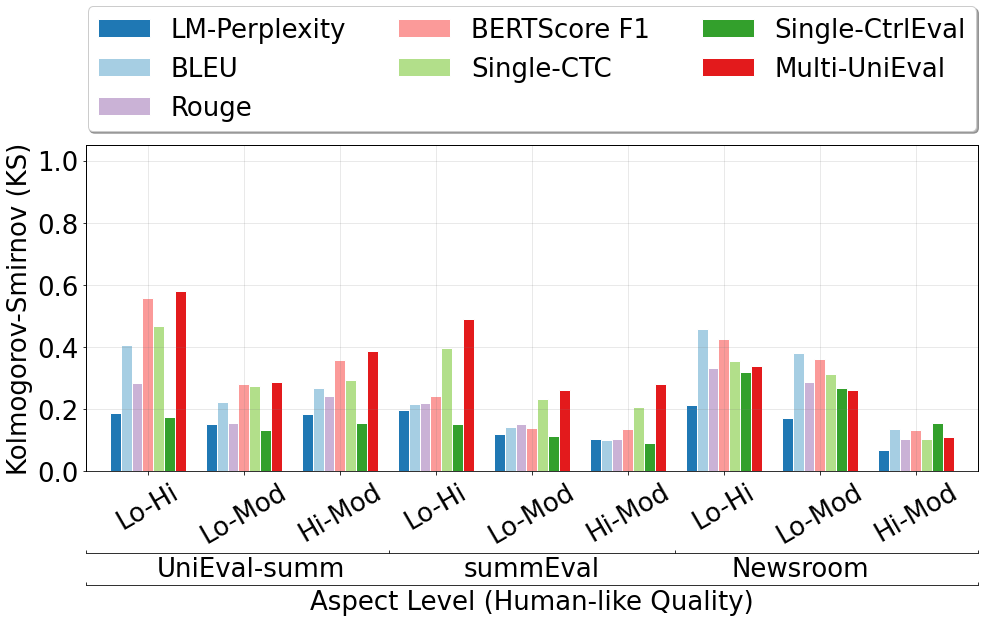

In [41]:
x = np.arange(9)
plt.clf()
colors = [ "#1F78B4", "#A6CEE3", "#CAB2D6", "#FB9A99",  "#B2DF8A", "#33A02C", "#E31A1C", "#FDBF6F", ]
sns.set_palette(sns.color_palette(colors))

fig1, ax1 = plt.subplots(1)
# plot grouped bar chart
df_ks1.plot(x='Difficulty_Level',
        kind='bar',
        stacked=False, edgecolor='white', width=.8, ax=ax1)

levels = ['Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod']

ax1.set_xticks(range(len(x)), levels, rotation=30)
ax1.set_xlabel('')
plt.ylabel('Kolmogorov-Smirnov (KS)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.465),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color="grey", alpha=0.215)
plt.ylim(0., 1.05)

# Second X-axis
ax2 = ax1.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.34, 0.66, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.185, 0.5, 0.8]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['UniEval-summ', 'summEval', 'Newsroom']))

# Third X-axis
ax3 = ax1.twiny()

ax3.spines["bottom"].set_position(("axes", -0.35))
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['Aspect Level (Human-like Quality)']))

plt.show()
#plt.savefig('../figures/ks_summ_aspect.pdf',bbox_inches='tight',pad_inches=0.05)

## Discerning System-level Performance On Controllable Generation

In [42]:

# For Controlled Generation



df_ks2 = pd.DataFrame([['Lo-Hi1',0.1963415735769367, 0.1191593827631243, 0.14338529396223265, \
                       0.10970776742567341, 0.029128997448715315], # UBER Topic \
                   ['Lo-Mod1',0.15870842839795585, 0.08365552840125079, 0.10348915403848624, \
                   0.09306291896185725, 0.02657909068528768], # # UBER Topic \
                    ['Hi-Mod1',0.10383001545467421, 0.03544223114409134, 0.05920719035759351, \
                    0.06548336714675361, 0.01439852340747522], # # UBER Topic \
                   ['Lo-Hi2', 0.08734696830353583, 0.14966929081478197, 0.10805100289509754, \
                   0.17248893622964898, 0.10147577964167327], #  CTRL Topic \
                   ['Lo-Mod2',0.10275456057965877, 0.10593441428669877, 0.11852748817809805, \
                   0.11084694369788438, 0.1351565807220138], #  CTRL Topic \
                    ['Hi-Mod2',0.09384762944109104, 0.06345485787491909, 0.06011256582061545, \
                    0.06432745763248005, 0.0629186902869615] # CTRL Topic 
                      ],
                       columns=['Difficulty_Level', 'LM-Perplexity', 'BERTScore F1',\
                                'Single-CTC', 'Single-CtrlEval', 'Multi-UniEval'])


In [43]:
df_ks2

,Difficulty_Level,LM-Perplexity,BERTScore F1,Single-CTC,Single-CtrlEval,Multi-UniEval
0,Lo-Hi1,0.196342,0.119159,0.143385,0.109708,0.029129
1,Lo-Mod1,0.158708,0.083656,0.103489,0.093063,0.026579
2,Hi-Mod1,0.103830,0.035442,0.059207,0.065483,0.014399
3,Lo-Hi2,0.087347,0.149669,0.108051,0.172489,0.101476
4,Lo-Mod2,0.102755,0.105934,0.118527,0.110847,0.135157
5,Hi-Mod2,0.093848,0.063455,0.060113,0.064327,0.062919


<Figure size 1152x432 with 0 Axes>

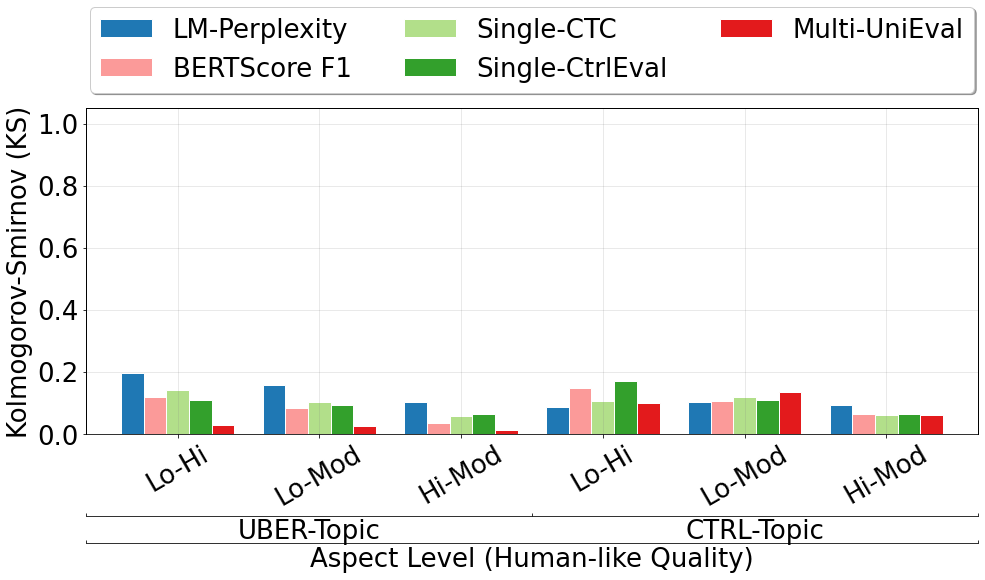

In [44]:
x = np.arange(6)
plt.clf()
colors = [ "#1F78B4", "#FB9A99",  "#B2DF8A", "#33A02C", "#E31A1C", "#FDBF6F", ]
sns.set_palette(sns.color_palette(colors))

fig1, ax1 = plt.subplots(1)
# plot grouped bar chart
df_ks2.plot(x='Difficulty_Level',
        kind='bar',
        stacked=False, edgecolor='white', width=.8, ax=ax1)

levels = ['Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod']

ax1.set_xticks(range(len(x)), levels, rotation=30)
ax1.set_xlabel('')
plt.ylabel('Kolmogorov-Smirnov (KS)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color="grey", alpha=0.215)
plt.ylim(0., 1.05)

# Second X-axis
ax2 = ax1.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.5, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.25, 0.75, 0.9]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['UBER-Topic', 'CTRL-Topic']))

# Third X-axis
ax3 = ax1.twiny()

ax3.spines["bottom"].set_position(("axes", -0.335))
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['Aspect Level (Human-like Quality)']))

plt.show()
#plt.savefig('../figures/ks_ctrlgen_aspect.pdf',bbox_inches='tight',pad_inches=0.05)

## Discerning System-level Performance on Dialogue Response Generation

In [45]:

# For Dialogue Response Generation


df_ks3 = pd.DataFrame([['Lo-Hi1',0.22445612949788638, 0.2861635220125786, 0.40225796473863284, \
                       0.14094236519228787, 0.37305392308485413,0.09903082792040417,0.5337148159604083 ], # UniEval TC\
                   ['Lo-Mod1', 0.17274580420551341, 0.16171392744719928, 0.23452473441092894, \
                   0.11507134225419914,0.3006689811824261,0.1360236478508663,0.3753772501388224 ], # UniEval TC \
                    ['Hi-Mod1', 0.13145880888151068, 0.09970948329528947, 0.2670678564017431, \
                    0.18520439925295704,0.3722764058933388,0.17031541813654286,0.334941550805838 ], # UniEval TC \
                   ['Lo-Hi2', 0.20441360360215313, 0.23363011382846838, 0.24345414933650225, \
                   0.09167458260211557,0.3303941509734365,0.153034263030882,0.3733969112645997  ], # USR-TC \
                   ['Lo-Mod2', 0.14960624677823245, 0.14072028985103144, 0.12407331061897904, \
                   0.07350172314433291,0.2227897158598169,0.11999231782258918,0.24994848929591248 ], # USR-TC \
                    ['Hi-Mod2', 0.19240929376213253, 0.1511937401188737, 0.22014260249554365, \
                    0.11906381956813224,0.2903283369022127,0.12546779002981848,0.29953904754280986 ], # USR-TC \
                   ['Lo-Hi3', 0.36894434541493365, 0.17068726480491186, 0.30512040271986174, \
                   0.09126559714795009,0.2936951211461015,0.10901168548227373,0.38453819238132964 ], # USR-PC \
                   ['Lo-Mod3', 0.22512654191185816, 0.08252039507492273, 0.18752659100037306, \
                   0.11288058171580462,0.1945871755113433,0.09468479194253154, 0.2290488076103834], # USR-PC \
                    ['Hi-Mod3', 0.19563279857397503, 0.15552584670231728, 0.22379875522824152, \
                    0.13680926916221034,0.27510398098633393,0.11437908496732026,0.29530600118835415], # USR-PC    
                      ],
                       columns=['Difficulty_Level', 'LM-Perplexity', 'BLEU', 'Rouge', 'BERTScore F1',\
                                'Single-CTC', 'Single-CtrlEval', 'Multi-UniEval'])


In [46]:
df_ks3

,Difficulty_Level,LM-Perplexity,BLEU,Rouge,BERTScore F1,Single-CTC,Single-CtrlEval,Multi-UniEval
0,Lo-Hi1,0.224456,0.286164,0.402258,0.140942,0.373054,0.099031,0.533715
1,Lo-Mod1,0.172746,0.161714,0.234525,0.115071,0.300669,0.136024,0.375377
2,Hi-Mod1,0.131459,0.099709,0.267068,0.185204,0.372276,0.170315,0.334942
3,Lo-Hi2,0.204414,0.233630,0.243454,0.091675,0.330394,0.153034,0.373397
4,Lo-Mod2,0.149606,0.140720,0.124073,0.073502,0.222790,0.119992,0.249948
5,Hi-Mod2,0.192409,0.151194,0.220143,0.119064,0.290328,0.125468,0.299539
6,Lo-Hi3,0.368944,0.170687,0.305120,0.091266,0.293695,0.109012,0.384538
7,Lo-Mod3,0.225127,0.082520,0.187527,0.112881,0.194587,0.094685,0.229049
8,Hi-Mod3,0.195633,0.155526,0.223799,0.136809,0.275104,0.114379,0.295306


<Figure size 1152x432 with 0 Axes>

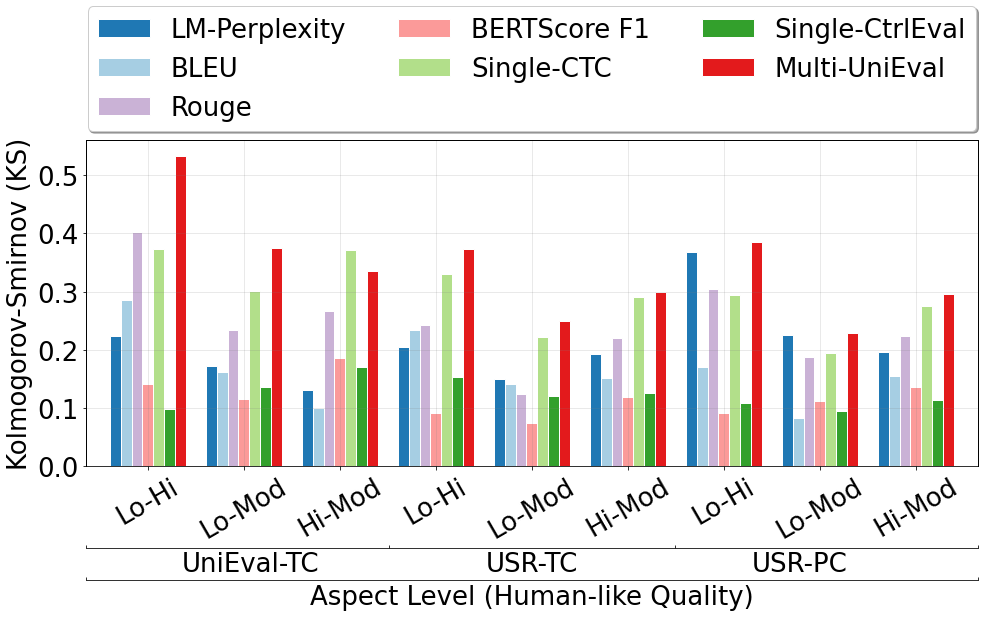

In [47]:
x = np.arange(9)
plt.clf()
colors = [ "#1F78B4", "#A6CEE3", "#CAB2D6", "#FB9A99",  "#B2DF8A", "#33A02C", "#E31A1C", "#FDBF6F", ]
sns.set_palette(sns.color_palette(colors))

fig1, ax1 = plt.subplots(1)
# plot grouped bar chart
df_ks3.plot(x='Difficulty_Level',
        kind='bar',
        stacked=False, edgecolor='white', width=.8, ax=ax1)

levels = ['Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod']

ax1.set_xticks(range(len(x)), levels, rotation=30)
ax1.set_xlabel('')
plt.ylabel('Kolmogorov-Smirnov (KS)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color="grey", alpha=0.215)
#plt.ylim(-0.2, 0.5)

# Second X-axis
ax2 = ax1.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.34, 0.66, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.185, 0.5, 0.8]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['UniEval-TC', 'USR-TC', 'USR-PC']))

# Third X-axis
ax3 = ax1.twiny()

ax3.spines["bottom"].set_position(("axes", -0.35))
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['Aspect Level (Human-like Quality)']))

plt.show()
#plt.savefig('../figures/ks_diag_aspect.pdf',bbox_inches='tight',pad_inches=0.05)

## Compute the preference similarity based on levensthein distance

### sim = (L1_correct + L2)-LevD/(L1+L2)

In [48]:
from Levenshtein import *
from Levenshtein import distance as lev

In [49]:
# function to calculate the similarity between preference pairs of automated metrics and human metrics
def compute_sim_preference(pref_automm, pref_humm):
    # both pref_automm and pref_humm are string
    lev_dist = lev(pref_automm, pref_humm)
    sim = (len(pref_automm) + len(pref_humm) - (2*lev_dist) )/(len(pref_automm) + len(pref_humm))
    return sim
    

## Preference similarity between human aspects 

In [50]:
i=0
dat_scores_lohi = {}
dat_scores_lomod = {}
dat_scores_himod = {}
for k in dfs.keys():
    print(k)
    df_lohi = data_sys_prefer_lohi[k]
    df_lomod = data_sys_prefer_lomod[k]
    df_himod = data_sys_prefer_himod[k]
    met_scores_lohi = {}
    met_scores_lomod = {}
    met_scores_himod = {}
    for automm in autom_metr[i]:
        #print(automm)
        # get preference of autom metrics
        pref_autom_lohi = df_lohi[automm]
        pref_autom_lomod = df_lomod[automm]
        pref_autom_himod = df_himod[automm]

        scores_lohi = []
        scores_lomod = []
        scores_himod = []
        for humm in hum_metr[i]:
            #print(humm)
            # get preference of human metrics
            if humm in list(df_lohi.keys()):
                pref_humm_lohi = df_lohi[humm]
                sim_lohi = compute_sim_preference(pref_autom_lohi[humm], pref_humm_lohi)
                scores_lohi.append(sim_lohi)
            
            if humm in list(df_lomod.keys()):
                pref_humm_lomod = df_lomod[humm]
                sim_lomod = compute_sim_preference(pref_autom_lomod[humm], pref_humm_lomod)
                scores_lomod.append(sim_lomod)
            
            if humm in list(df_himod.keys()):
                pref_humm_himod = df_himod[humm]
                sim_himod = compute_sim_preference(pref_autom_himod[humm], pref_humm_himod)
                scores_himod.append(sim_himod)

        met_scores_lohi[automm] = np.mean(scores_lohi)
        met_scores_lomod[automm] = np.mean(scores_lomod)
        met_scores_himod[automm] = np.mean(scores_himod)
    dat_scores_lohi[k] = met_scores_lohi
    dat_scores_lomod[k] = met_scores_lomod
    dat_scores_himod[k] = met_scores_himod
    i+=1
    

unieval_summeval.csv
summeval_large.csv
newsroom.csv
unieval_topical_chat.csv
usr_persona_chat.csv
usr_topical_chat.csv
uber_topic.csv
ctrl_topic.csv


## Preference similarity score Low vs High

In [51]:
dat_scores_lohi

{'unieval_summeval.csv': {'perplexity': 0.8,
  'bleu': 1.0,
  'rouge1': 1.0,
  'rouge2': 1.0,
  'rougeL': 1.0,
  'bert_f1_src': 1.0,
  'bert_f1_ttl': 1.0,
  'coherence_unieval': 1.0,
  'consistency_unieval': 1.0,
  'fluency_unieval': 1.0,
  'relevance_unieval': 1.0,
  'overall_unieval': 1.0,
  'ctc_e_consisten': 1.0,
  'ctc_e_relev': 1.0,
  'ctc_d_consisten': 1.0,
  'ctc_d_relev': 1.0,
  'ctc_r_consisten': 1.0,
  'ctc_r_relev': 1.0,
  'cohere_met': 0.8},
 'summeval_large.csv': {'perplexity': 0.75,
  'bleu1': 1.0,
  'bleu11': 1.0,
  'rouge_l_f_score1': 1.0,
  'rouge_l_f_score11': 1.0,
  'bert_score_f1': 1.0,
  'bert_score_f11': 1.0,
  'coherence_unieval': 1.0,
  'consistency_unieval': 1.0,
  'fluency_unieval': 1.0,
  'relevance_unieval': 1.0,
  'overall_unieval': 1.0,
  'ctc_e_consisten': 1.0,
  'ctc_e_relev': 1.0,
  'ctc_d_consisten': 1.0,
  'ctc_d_relev': 1.0,
  'ctc_r_consisten': 1.0,
  'ctc_r_relev': 1.0,
  'cohere_met': 1.0},
 'newsroom.csv': {'perplexity': 1.0,
  'bleu': 1.0,
  'r

## Preference similarity score Low vs Moderate

In [52]:
dat_scores_lomod

{'unieval_summeval.csv': {'perplexity': 0.8,
  'bleu': 1.0,
  'rouge1': 1.0,
  'rouge2': 1.0,
  'rougeL': 1.0,
  'bert_f1_src': 1.0,
  'bert_f1_ttl': 1.0,
  'coherence_unieval': 1.0,
  'consistency_unieval': 1.0,
  'fluency_unieval': 1.0,
  'relevance_unieval': 1.0,
  'overall_unieval': 1.0,
  'ctc_e_consisten': 1.0,
  'ctc_e_relev': 1.0,
  'ctc_d_consisten': 1.0,
  'ctc_d_relev': 1.0,
  'ctc_r_consisten': 1.0,
  'ctc_r_relev': 1.0,
  'cohere_met': 0.8},
 'summeval_large.csv': {'perplexity': 0.75,
  'bleu1': 1.0,
  'bleu11': 1.0,
  'rouge_l_f_score1': 1.0,
  'rouge_l_f_score11': 1.0,
  'bert_score_f1': 1.0,
  'bert_score_f11': 1.0,
  'coherence_unieval': 1.0,
  'consistency_unieval': 1.0,
  'fluency_unieval': 1.0,
  'relevance_unieval': 1.0,
  'overall_unieval': 1.0,
  'ctc_e_consisten': 1.0,
  'ctc_e_relev': 1.0,
  'ctc_d_consisten': 1.0,
  'ctc_d_relev': 1.0,
  'ctc_r_consisten': 1.0,
  'ctc_r_relev': 1.0,
  'cohere_met': 0.75},
 'newsroom.csv': {'perplexity': 1.0,
  'bleu': 1.0,
  '

## Preference similarity score High vs Moderate

In [53]:
dat_scores_himod

{'unieval_summeval.csv': {'perplexity': 0.6,
  'bleu': 1.0,
  'rouge1': 1.0,
  'rouge2': 1.0,
  'rougeL': 1.0,
  'bert_f1_src': 1.0,
  'bert_f1_ttl': 1.0,
  'coherence_unieval': 1.0,
  'consistency_unieval': 1.0,
  'fluency_unieval': 1.0,
  'relevance_unieval': 1.0,
  'overall_unieval': 1.0,
  'ctc_e_consisten': 1.0,
  'ctc_e_relev': 1.0,
  'ctc_d_consisten': 1.0,
  'ctc_d_relev': 1.0,
  'ctc_r_consisten': 1.0,
  'ctc_r_relev': 1.0,
  'cohere_met': 0.6},
 'summeval_large.csv': {'perplexity': 0.5,
  'bleu1': 1.0,
  'bleu11': 0.75,
  'rouge_l_f_score1': 1.0,
  'rouge_l_f_score11': 1.0,
  'bert_score_f1': 1.0,
  'bert_score_f11': 1.0,
  'coherence_unieval': 1.0,
  'consistency_unieval': 1.0,
  'fluency_unieval': 1.0,
  'relevance_unieval': 1.0,
  'overall_unieval': 1.0,
  'ctc_e_consisten': 1.0,
  'ctc_e_relev': 1.0,
  'ctc_d_consisten': 1.0,
  'ctc_d_relev': 1.0,
  'ctc_r_consisten': 1.0,
  'ctc_r_relev': 1.0,
  'cohere_met': 1.0},
 'newsroom.csv': {'perplexity': 1.0,
  'bleu': 1.0,
  'r

In [54]:
dat_scores_lohi.keys()

dict_keys(['unieval_summeval.csv', 'summeval_large.csv', 'newsroom.csv', 'unieval_topical_chat.csv', 'usr_persona_chat.csv', 'usr_topical_chat.csv', 'uber_topic.csv', 'ctrl_topic.csv'])

In [55]:
dat1 = ['unieval_summeval.csv', 'summeval_large.csv', \
        'newsroom.csv'] # Text Summarization
dat2 = ['unieval_topical_chat.csv', 'usr_topical_chat.csv', 'usr_persona_chat.csv', \
        ] # Dialogue Response Generation
dat3 = [ 'uber_topic.csv', \
         'ctrl_topic.csv'] # Controlled Generation

In [56]:
for p in autom_metr:
    print(p)
    print()

['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', 'coherence_unieval', 'consistency_unieval', 'fluency_unieval', 'relevance_unieval', 'overall_unieval', 'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', 'ctc_r_consisten', 'ctc_r_relev', 'cohere_met']

['perplexity', 'bleu1', 'bleu11', 'rouge_l_f_score1', 'rouge_l_f_score11', 'bert_score_f1', 'bert_score_f11', 'coherence_unieval', 'consistency_unieval', 'fluency_unieval', 'relevance_unieval', 'overall_unieval', 'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', 'ctc_r_consisten', 'ctc_r_relev', 'cohere_met']

['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_src', 'bert_f1_ttl', 'coherence_unieval', 'consistency_unieval', 'fluency_unieval', 'relevance_unieval', 'overall_unieval', 'ctc_e_consisten', 'ctc_e_relev', 'ctc_d_consisten', 'ctc_d_relev', 'ctc_r_consisten', 'ctc_r_relev', 'cohere_met']

['perplexity', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'bert_f1_sr

In [57]:
# Text Summarization
for d in dat1:
    print(d)
    df_lohi = dat_scores_lohi[d]
    df_lomod = dat_scores_lomod[d]
    df_himod = dat_scores_himod[d]
    
    print("Perplexity")
    print(df_lohi['perplexity'])
    print()
    print(df_lomod['perplexity'])
    print()
    print(df_himod['perplexity'])
    print("=====")
    
    print("BLEU")
    if d == 'summeval_large.csv':
        print(np.mean([df_lohi['bleu1'], df_lohi['bleu11'] ]))
        print()
        print(np.mean([df_lomod['bleu1'], df_lomod['bleu11'] ]))
        print()
        print(np.mean([df_himod['bleu1'], df_himod['bleu11'] ]))
        print("=====")
    else:
        print(df_lohi['bleu'])
        print()
        print(df_lomod['bleu'])
        print()
        print(df_himod['bleu'])
        print("=====")
        
    print("ROUGE")
    if d == 'summeval_large.csv':
        print(np.mean([df_lohi['rouge_l_f_score1'], df_lohi['rouge_l_f_score11'] ]))
        print()
        print(np.mean([df_lomod['rouge_l_f_score1'], df_lomod['rouge_l_f_score11'] ]))
        print()
        print(np.mean([df_himod['rouge_l_f_score1'], df_himod['rouge_l_f_score11'] ]))
        print("=====")
    else:
        print(np.mean([df_lohi['rouge1'], df_lohi['rouge2'], df_lohi['rougeL'] ]))
        print()
        print(np.mean([df_lomod['rouge1'], df_lomod['rouge2'], df_lomod['rougeL'] ]))
        print()
        print(np.mean([df_himod['rouge1'], df_himod['rouge2'], df_himod['rougeL'] ]))
        
        print("=====")
    
    print("BERTScore")
    
    if d in ['unieval_summeval.csv', 'newsroom.csv', 'unieval_topical_chat.csv', \
                'usr_persona_chat.csv', 'usr_topical_chat.csv']:
        
        print(df_lohi['bert_f1_src'])
        print()
        print(df_lomod['bert_f1_src'])
        print()
        print(df_himod['bert_f1_src'])
        print("=====")
        
    else:
        if d == 'summeval_large.csv':
            print(np.mean([df_lohi['bert_score_f1'], df_lohi['bert_score_f11'] ]))
            print()
            print(np.mean([df_lomod['bert_score_f1'], df_lomod['bert_score_f11'] ]))
            print()
            print(np.mean([df_himod['bert_score_f1'], df_himod['bert_score_f11'] ]))
            print("=====")
        else:
            print(df_lohi['bert_f1'])
            print()
            print(df_lomod['bert_f1'])
            print()
            print(df_himod['bert_f1'])
            print("=====")
    
    
    print("Unieval")
    
    print(np.mean([df_lohi['consistency_unieval'], df_lohi['fluency_unieval'], df_lohi['relevance_unieval'],\
                  df_lohi['overall_unieval']]))
    print()
    print(np.mean([df_lomod['consistency_unieval'], df_lomod['fluency_unieval'], df_lomod['relevance_unieval'],\
                  df_lomod['overall_unieval']]))
    print()
    print(np.mean([df_himod['consistency_unieval'], df_himod['fluency_unieval'], df_himod['relevance_unieval'],\
                  df_lomod['overall_unieval']]))
        
    print("=====")
    
    
    
    
    # CTC
    print("CTC")
    print(np.mean([df_lohi['ctc_e_consisten'], df_lohi['ctc_e_relev'], df_lohi['ctc_d_consisten'],\
                  df_lohi['ctc_d_relev'], df_lohi['ctc_r_consisten'], df_lohi['ctc_r_relev']]))
    print()
    print(np.mean([df_lomod['ctc_e_consisten'], df_lomod['ctc_e_relev'], df_lomod['ctc_d_consisten'],\
                  df_lomod['ctc_d_relev'], df_lomod['ctc_r_consisten'], df_lomod['ctc_r_relev']]))
    print()
    print(np.mean([df_himod['ctc_e_consisten'], df_himod['ctc_e_relev'], df_himod['ctc_d_consisten'],\
                  df_lomod['ctc_d_relev'], df_lomod['ctc_r_consisten'], df_lomod['ctc_r_relev']]))
        
    print("=====")
    
    
    
    print("CtrlEval")
    
    #'cohere_met', 'consist_met', 'relev_met'
    print(df_lohi['cohere_met'])
    print()
    print(df_lomod['cohere_met'])
    print()
    print(df_himod['cohere_met'])
        
    print("=====")
    
    
            
    

unieval_summeval.csv
Perplexity
0.8

0.8

0.6
=====
BLEU
1.0

1.0

1.0
=====
ROUGE
1.0

1.0

1.0
=====
BERTScore
1.0

1.0

1.0
=====
Unieval
1.0

1.0

1.0
=====
CTC
1.0

1.0

1.0
=====
CtrlEval
0.8

0.8

0.6
=====
summeval_large.csv
Perplexity
0.75

0.75

0.5
=====
BLEU
1.0

1.0

0.875
=====
ROUGE
1.0

1.0

1.0
=====
BERTScore
1.0

1.0

1.0
=====
Unieval
1.0

1.0

1.0
=====
CTC
1.0

1.0

1.0
=====
CtrlEval
1.0

0.75

1.0
=====
newsroom.csv
Perplexity
1.0

1.0

1.0
=====
BLEU
1.0

1.0

1.0
=====
ROUGE
1.0

1.0

0.5
=====
BERTScore
1.0

1.0

1.0
=====
Unieval
1.0

1.0

1.0
=====
CTC
1.0

1.0

1.0
=====
CtrlEval
1.0

1.0

1.0
=====


In [58]:
# Dialogue Generation

for d in dat2:
    print(d)
    df_lohi = dat_scores_lohi[d]
    df_lomod = dat_scores_lomod[d]
    df_himod = dat_scores_himod[d]
    
    print("Perplexity")
    print(df_lohi['perplexity'])
    print()
    print(df_lomod['perplexity'])
    print()
    print(df_himod['perplexity'])
    print("=====")
    
    print("BLEU")
    print(df_lohi['bleu'])
    print()
    print(df_lomod['bleu'])
    print()
    print(df_himod['bleu'])
    print("=====")
        
    print("ROUGE")
    print(np.mean([df_lohi['rouge1'], df_lohi['rouge2'], df_lohi['rougeL'] ]))
    print()
    print(np.mean([df_lomod['rouge1'], df_lomod['rouge2'], df_lomod['rougeL'] ]))
    print()
    print(np.mean([df_himod['rouge1'], df_himod['rouge2'], df_himod['rougeL'] ]))  
    print("=====")
    
    print("BERTScore")
    
    if d in ['unieval_summeval.csv', 'newsroom.csv', 'unieval_topical_chat.csv', \
                'usr_persona_chat.csv', 'usr_topical_chat.csv']:
        
        print(df_lohi['bert_f1_src'])
        print()
        print(df_lomod['bert_f1_src'])
        print()
        print(df_himod['bert_f1_src'])
        print("=====")
        
    
    
    print("Unieval")
    
    print(np.mean([df_lohi['understandability_unieval'], df_lohi['naturalness_unieval'], df_lohi['coherence_unieval'],\
                  df_lohi['engagingness_unieval'], df_lohi['groundedness_unieval'], df_lohi['overall_unieval']]))
    print()
    print(np.mean([df_lomod['understandability_unieval'], df_lomod['naturalness_unieval'], df_lomod['coherence_unieval'],\
                  df_lomod['engagingness_unieval'], df_lomod['groundedness_unieval'], df_lomod['overall_unieval']]))
    print()
    print(np.mean([df_himod['understandability_unieval'], df_himod['naturalness_unieval'], df_himod['coherence_unieval'],\
                  df_lomod['engagingness_unieval'], df_lomod['groundedness_unieval'], df_lomod['overall_unieval']]))
        
    print("=====")
    
    
    
    
    # CTC
    print("CTC")
    print(np.mean([df_lohi['ctc_e_engage'], df_lohi['ctc_e_ground'], df_lohi['ctc_d_engage'],\
                  df_lohi['ctc_d_ground'], df_lohi['ctc_r_engage'], df_lohi['ctc_r_ground']]))
    print()
    print(np.mean([df_lomod['ctc_e_engage'], df_lomod['ctc_e_ground'], df_lomod['ctc_d_engage'],\
                  df_lomod['ctc_d_ground'], df_lomod['ctc_r_engage'], df_lomod['ctc_r_ground']]))
    print()
    print(np.mean([df_himod['ctc_e_engage'], df_himod['ctc_e_ground'], df_himod['ctc_d_engage'],\
                  df_lomod['ctc_d_ground'], df_lomod['ctc_r_engage'], df_lomod['ctc_r_ground']]))
        
    print("=====")
    
    
    
    print("CtrlEval")
    
    #'cohere_met', 'consist_met', 'relev_met'
    print(df_lohi['cohere_met'])
    print()
    print(df_lomod['cohere_met'])
    print()
    print(df_himod['cohere_met'])
        
    print("=====")
    
    
            
    

unieval_topical_chat.csv
Perplexity
0.0

0.0

0.0
=====
BLEU
1.0

1.0

0.0
=====
ROUGE
1.0

1.0

1.0
=====
BERTScore
0.0

0.25

0.0
=====
Unieval
1.0

1.0

1.0
=====
CTC
1.0

0.9166666666666666

1.0
=====
CtrlEval
1.0

0.75

0.0
=====
usr_topical_chat.csv
Perplexity
0.0

0.0

0.0
=====
BLEU
1.0

1.0

1.0
=====
ROUGE
1.0

1.0

1.0
=====
BERTScore
0.0

0.5

0.0
=====
Unieval
1.0

0.9166666666666666

1.0
=====
CTC
1.0

1.0

1.0
=====
CtrlEval
1.0

0.75

0.0
=====
usr_persona_chat.csv
Perplexity
0.0

0.0

0.0
=====
BLEU
1.0

0.75

1.0
=====
ROUGE
1.0

0.75

1.0
=====
BERTScore
1.0

0.75

0.0
=====
Unieval
1.0

1.0

1.0
=====
CTC
1.0

0.8333333333333334

0.9166666666666666
=====
CtrlEval
1.0

1.0

1.0
=====


In [59]:
# Controlled Generation
for d in dat3:
    print(d)
    df_lohi = dat_scores_lohi[d]
    df_lomod = dat_scores_lomod[d]
    df_himod = dat_scores_himod[d]
    
    print("Perplexity")
    print(df_lohi['perplexity'])
    print()
    print(df_lomod['perplexity'])
    print()
    print(df_himod['perplexity'])
    print("=====")
    
    
    
    print("BERTScore")
    
    if d in ['unieval_summeval.csv', 'newsroom.csv', 'unieval_topical_chat.csv', \
                'usr_persona_chat.csv', 'usr_topical_chat.csv']:
        
        print(df_lohi['bert_f1_src'])
        print()
        print(df_lomod['bert_f1_src'])
        print()
        print(df_himod['bert_f1_src'])
        print("=====")
        
    else:
        if d == 'summeval_large.csv':
            print(np.mean([df_lohi['bert_score_f1'], df_lohi['bert_score_f11'] ]))
            print()
            print(np.mean([df_lomod['bert_score_f1'], df_lomod['bert_score_f11'] ]))
            print()
            print(np.mean([df_himod['bert_score_f1'], df_himod['bert_score_f11'] ]))
            print("=====")
        else:
            print(df_lohi['bert_f1'])
            print()
            print(df_lomod['bert_f1'])
            print()
            print(df_himod['bert_f1'])
            print("=====")
    
    
    print("Unieval")
    
    print(np.mean([df_lohi['consistency_unieval'], df_lohi['fluency_unieval'], df_lohi['relevance_unieval'],\
                  df_lohi['overall_unieval']]))
    print()
    print(np.mean([df_lomod['consistency_unieval'], df_lomod['fluency_unieval'], df_lomod['relevance_unieval'],\
                  df_lomod['overall_unieval']]))
    print()
    print(np.mean([df_himod['consistency_unieval'], df_himod['fluency_unieval'], df_himod['relevance_unieval'],\
                  df_lomod['overall_unieval']]))
        
    print("=====")
    
    
    
    
    # CTC
    print("CTC")
    print(np.mean([df_lohi['ctc_e_consisten'], df_lohi['ctc_e_relev'], df_lohi['ctc_d_consisten'],\
                  df_lohi['ctc_d_relev'], df_lohi['ctc_r_consisten'], df_lohi['ctc_r_relev']]))
    print()
    print(np.mean([df_lomod['ctc_e_consisten'], df_lomod['ctc_e_relev'], df_lomod['ctc_d_consisten'],\
                  df_lomod['ctc_d_relev'], df_lomod['ctc_r_consisten'], df_lomod['ctc_r_relev']]))
    print()
    print(np.mean([df_himod['ctc_e_consisten'], df_himod['ctc_e_relev'], df_himod['ctc_d_consisten'],\
                  df_lomod['ctc_d_relev'], df_lomod['ctc_r_consisten'], df_lomod['ctc_r_relev']]))
        
    print("=====")
    
    
    print("CtrlEval")
    
    #'cohere_met', 'consist_met', 'relev_met'
    print(np.mean([df_lohi['cohere_met'], df_lohi['consist_met'], df_lohi['relev_met']]))
    print()
    print(np.mean([df_lomod['cohere_met'], df_lomod['consist_met'], df_lomod['relev_met']]))
    print()
    print(np.mean([df_himod['cohere_met'], df_himod['consist_met'], df_himod['relev_met']]))
        
    print("=====")
    
    
            
    

uber_topic.csv
Perplexity
0.5

1.0

1.0
=====
BERTScore
1.0

1.0

1.0
=====
Unieval
0.5

0.75

0.5
=====
CTC
0.4166666666666667

0.6666666666666666

0.8333333333333334
=====
CtrlEval
0.6666666666666666

1.0

0.6666666666666666
=====
ctrl_topic.csv
Perplexity
0.0

0.0

1.0
=====
BERTScore
1.0

1.0

1.0
=====
Unieval
0.5

1.0

0.5
=====
CTC
0.4166666666666667

0.3333333333333333

0.5
=====
CtrlEval
0.16666666666666666

0.0

0.3333333333333333
=====


## Text Summarization

In [60]:
# TextSumm

df_sim1 = pd.DataFrame([['Lo-Hi1', 0.8, 1.0, 1.0, 1.0,1.0, 0.8, 1.0], # UniEval summEval\
                   ['Lo-Mod1', 0.8, 1.0, 1.0,  1.0,1.0, 0.8, 1.0], # UniEval summEval \
                   ['Hi-Mod1', 0.6, 1.0, 1.0, 1.0,1.0, 0.6 , 1.0], # UniEval summEval \
                   ['Lo-Hi2', 0.75, 1.0, 1.0, 1.0,1.0, 1.0, 1.0], # summEval \
                   ['Lo-Mod2', 0.75, 1.0, 1.0,1.0,1.0, 0.75 , 1.0], # summEval \
                   ['Hi-Mod2', 0.5, 0.875, 1.0, 1.0,1.0, 1.0, 1.0], # summEval \
                    ['Lo-Hi3', 1.0, 1.0,1.0,1.0,1.0, 1.0, 1.0 ], # newsroom \
                   ['Lo-Mod3', 1.0, 1.0,1.0,1.0,1.0, 1.0, 1.0], # newsroom \
                   ['Hi-Mod3', 1.0,1.0,0.5,  1.0,1.0, 1.0, 1.0], # newsroom  
                      ],
                       columns=['Difficulty_Level', 'LM-Perplexity', 'BLEU', 'Rouge', 'BERTScore F1', 'Single-CTC', \
                                'Single-CTRLEval', 'Multi-UniEval'])
                  

In [61]:
df_sim1

,Difficulty_Level,LM-Perplexity,BLEU,Rouge,BERTScore F1,Single-CTC,Single-CTRLEval,Multi-UniEval
0,Lo-Hi1,0.80,1.000,1.0,1.0,1.0,0.80,1.0
1,Lo-Mod1,0.80,1.000,1.0,1.0,1.0,0.80,1.0
2,Hi-Mod1,0.60,1.000,1.0,1.0,1.0,0.60,1.0
3,Lo-Hi2,0.75,1.000,1.0,1.0,1.0,1.00,1.0
4,Lo-Mod2,0.75,1.000,1.0,1.0,1.0,0.75,1.0
5,Hi-Mod2,0.50,0.875,1.0,1.0,1.0,1.00,1.0
6,Lo-Hi3,1.00,1.000,1.0,1.0,1.0,1.00,1.0
7,Lo-Mod3,1.00,1.000,1.0,1.0,1.0,1.00,1.0
8,Hi-Mod3,1.00,1.000,0.5,1.0,1.0,1.00,1.0


## Controlled Generation

In [62]:
# CtrlGen

df_sim3 = pd.DataFrame([['Lo-Hi1', 0.5 , 1.0, 0.4166666666666667, 0.6666666666666666, 0.5 ], # UBER\
                   ['Lo-Mod1', 1.0, 1.0, 0.6666666666666666, 1.0, 0.75], # UBER \
                   ['Hi-Mod1', 1.0, 1.0, 0.8333333333333334 , 0.6666666666666666,0.5 ], # UBER \
                   ['Lo-Hi2', 0.0, 1.0, 0.4166666666666667 , 0.16666666666666666, 0.5], # CTRL \
                   ['Lo-Mod2', 0.0, 1.0, 0.3333333333333333 ,0.0 , 1.0], # CTRL \
                   ['Hi-Mod2', 1.0, 1.0, 0.5, 0.3333333333333333, 0.5] # CTRL 
                       ],
                       columns=['Difficulty_Level', 'LM-Perplexity', 'BERTScore F1', 'Single-CTC', \
                                'Single-CTRLEval', 'Multi-UniEval'])
                  

In [63]:
df_sim3

,Difficulty_Level,LM-Perplexity,BERTScore F1,Single-CTC,Single-CTRLEval,Multi-UniEval
0,Lo-Hi1,0.5,1.0,0.416667,0.666667,0.50
1,Lo-Mod1,1.0,1.0,0.666667,1.000000,0.75
2,Hi-Mod1,1.0,1.0,0.833333,0.666667,0.50
3,Lo-Hi2,0.0,1.0,0.416667,0.166667,0.50
4,Lo-Mod2,0.0,1.0,0.333333,0.000000,1.00
5,Hi-Mod2,1.0,1.0,0.500000,0.333333,0.50


In [64]:
import seaborn as sns

In [65]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 14,6
rcParams.update({'font.size': 26})

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

<Figure size 1008x432 with 0 Axes>

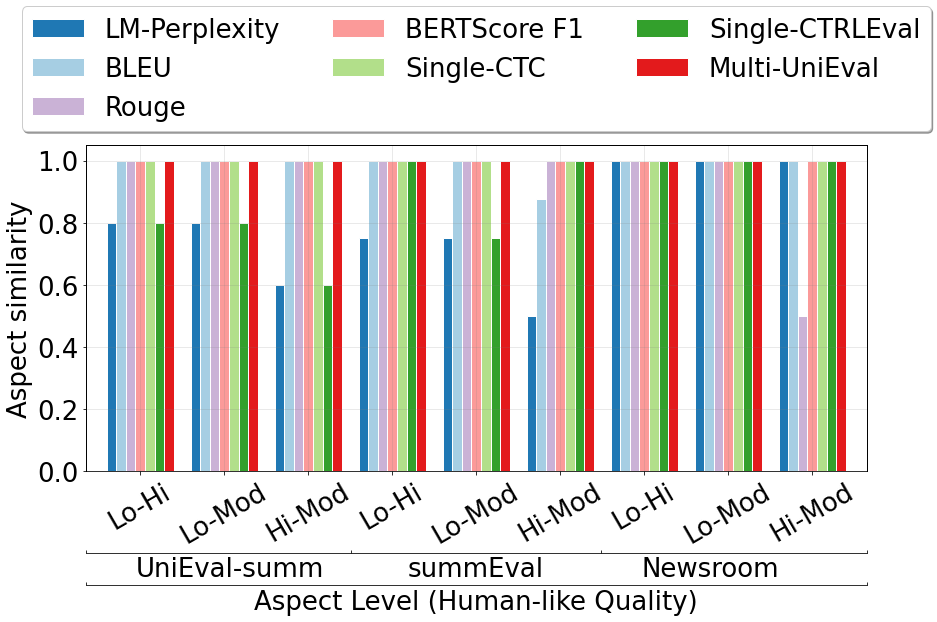

In [67]:
x = np.arange(9)
plt.clf()
colors = [ "#1F78B4", "#A6CEE3", "#CAB2D6", "#FB9A99",  "#B2DF8A", "#33A02C", "#E31A1C", "#FDBF6F", ]
sns.set_palette(sns.color_palette(colors))

fig1, ax1 = plt.subplots(1)
# plot grouped bar chart
df_sim1.plot(x='Difficulty_Level',
        kind='bar',
        stacked=False, edgecolor='white', width=.8, ax=ax1)

levels = ['Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod']

ax1.set_xticks(range(len(x)), levels, rotation=30)
ax1.set_xlabel('')
plt.ylabel('Aspect similarity')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.465),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color="grey", alpha=0.215)
plt.ylim(0., 1.05)

# Second X-axis
ax2 = ax1.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.34, 0.66, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.185, 0.5, 0.8]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['UniEval-summ', 'summEval', 'Newsroom']))

# Third X-axis
ax3 = ax1.twiny()

ax3.spines["bottom"].set_position(("axes", -0.35))
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['Aspect Level (Human-like Quality)']))

plt.show()
#plt.savefig('../figures/aspect_sim_summ.pdf',bbox_inches='tight',pad_inches=0.05)

In [68]:
df_sim3

,Difficulty_Level,LM-Perplexity,BERTScore F1,Single-CTC,Single-CTRLEval,Multi-UniEval
0,Lo-Hi1,0.5,1.0,0.416667,0.666667,0.50
1,Lo-Mod1,1.0,1.0,0.666667,1.000000,0.75
2,Hi-Mod1,1.0,1.0,0.833333,0.666667,0.50
3,Lo-Hi2,0.0,1.0,0.416667,0.166667,0.50
4,Lo-Mod2,0.0,1.0,0.333333,0.000000,1.00
5,Hi-Mod2,1.0,1.0,0.500000,0.333333,0.50


<Figure size 1008x432 with 0 Axes>

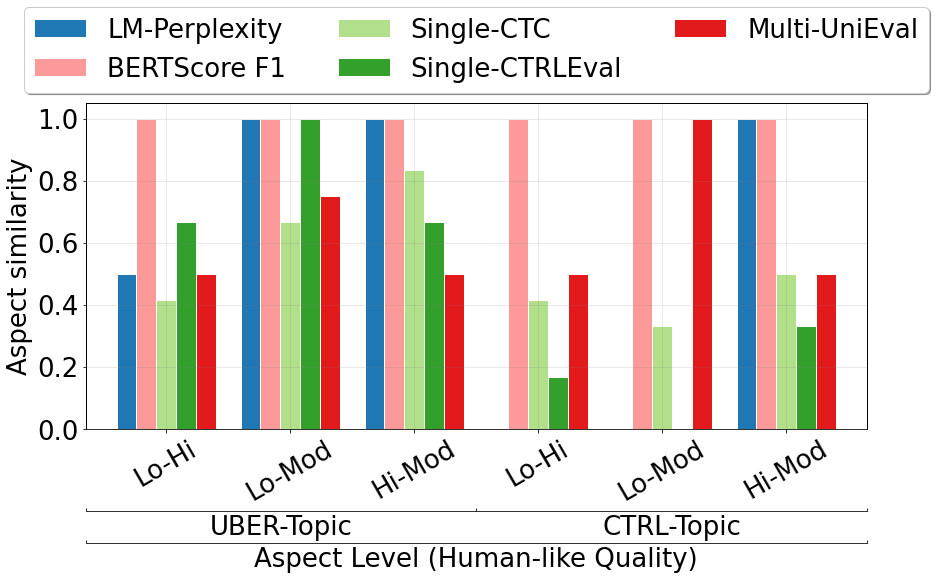

In [69]:
x = np.arange(6)
plt.clf()
colors = [ "#1F78B4", "#FB9A99",  "#B2DF8A", "#33A02C", "#E31A1C", "#FDBF6F", ]
sns.set_palette(sns.color_palette(colors))

fig1, ax1 = plt.subplots(1)
# plot grouped bar chart
df_sim3.plot(x='Difficulty_Level',
        kind='bar',
        stacked=False, edgecolor='white', width=.8, ax=ax1)

levels = ['Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod']

ax1.set_xticks(range(len(x)), levels, rotation=30)
ax1.set_xlabel('')
plt.ylabel('Aspect similarity')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.335),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color="grey", alpha=0.215)
plt.ylim(0., 1.05)

# Second X-axis
ax2 = ax1.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.5, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.25, 0.75, 0.9]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['UBER-Topic', 'CTRL-Topic']))

# Third X-axis
ax3 = ax1.twiny()

ax3.spines["bottom"].set_position(("axes", -0.35))
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['Aspect Level (Human-like Quality)']))

plt.show()
#plt.savefig('../figures/aspect_sim_ctrlgen.pdf',bbox_inches='tight',pad_inches=0.05)

## Dialogue Generation

In [70]:
# DiagGen

df_sim2 = pd.DataFrame([['Lo-Hi1', 0.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0], # UniEval summEval\
                   ['Lo-Mod1', 0.0, 1.0, 1.0,  0.25,0.9166666666666666, 0.75, 1.0], # UniEval summEval \
                   ['Hi-Mod1', 0.0, 0.0, 0.0, 0.0,1.0, 0.0 , 1.0], # UniEval summEval \
                   ['Lo-Hi2', 0.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0], # summEval \
                   ['Lo-Mod2', 0.0, 1.0, 1.0,0.5,1.0, 0.75 , 0.9166666666666666], # summEval \
                   ['Hi-Mod2', 0.0, 1.0, 1.0, 0.0,1.0, 0.0, 1.0], # summEval \
                    ['Lo-Hi3', 0.0, 1.0,1.0,1.0,1.0, 1.0, 1.0 ], # newsroom \
                   ['Lo-Mod3', 0.0, 0.75,0.75,0.75,0.8333333333333334, 1.0, 1.0], # newsroom \
                   ['Hi-Mod3', 0.0,1.0,1.0,  0.0,0.9166666666666666, 1.0, 1.0], # newsroom  
                      ],
                       columns=['Difficulty_Level', 'LM-Perplexity', 'BLEU', 'Rouge', 'BERTScore F1', 'Single-CTC', \
                                'Single-CTRLEval', 'Multi-UniEval'])
                  

In [71]:
df_sim2

,Difficulty_Level,LM-Perplexity,BLEU,Rouge,BERTScore F1,Single-CTC,Single-CTRLEval,Multi-UniEval
0,Lo-Hi1,0.0,1.00,1.00,0.00,1.000000,1.00,1.000000
1,Lo-Mod1,0.0,1.00,1.00,0.25,0.916667,0.75,1.000000
2,Hi-Mod1,0.0,0.00,0.00,0.00,1.000000,0.00,1.000000
3,Lo-Hi2,0.0,1.00,1.00,0.00,1.000000,1.00,1.000000
4,Lo-Mod2,0.0,1.00,1.00,0.50,1.000000,0.75,0.916667
5,Hi-Mod2,0.0,1.00,1.00,0.00,1.000000,0.00,1.000000
6,Lo-Hi3,0.0,1.00,1.00,1.00,1.000000,1.00,1.000000
7,Lo-Mod3,0.0,0.75,0.75,0.75,0.833333,1.00,1.000000
8,Hi-Mod3,0.0,1.00,1.00,0.00,0.916667,1.00,1.000000


<Figure size 1008x432 with 0 Axes>

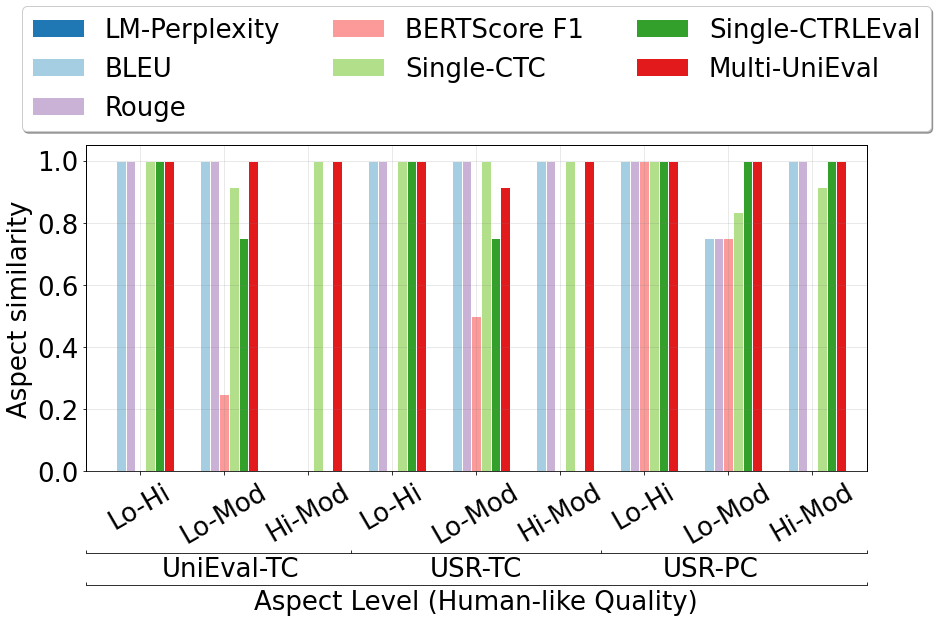

In [72]:
x = np.arange(9)
plt.clf()
colors = [ "#1F78B4", "#A6CEE3", "#CAB2D6", "#FB9A99",  "#B2DF8A", "#33A02C", "#E31A1C", "#FDBF6F", ]
sns.set_palette(sns.color_palette(colors))

fig1, ax1 = plt.subplots(1)
# plot grouped bar chart
df_sim2.plot(x='Difficulty_Level',
        kind='bar',
        stacked=False, edgecolor='white', width=.8, ax=ax1)

levels = ['Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod', 'Lo-Hi', 'Lo-Mod', 'Hi-Mod']

ax1.set_xticks(range(len(x)), levels, rotation=30)
ax1.set_xlabel('')
plt.ylabel('Aspect similarity')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.465),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color="grey", alpha=0.215)
plt.ylim(0., 1.05)

# Second X-axis
ax2 = ax1.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.34, 0.66, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.185, 0.5, 0.8]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['UniEval-TC', 'USR-TC', 'USR-PC']))

# Third X-axis
ax3 = ax1.twiny()

ax3.spines["bottom"].set_position(("axes", -0.35))
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['Aspect Level (Human-like Quality)']))

plt.show()
#plt.savefig('../figures/aspect_sim_diag.pdf',bbox_inches='tight',pad_inches=0.05)